# COMP8240 - Reproducibility Project

**Student ID:** 48097144

**Name:** Ankita Deepak DIMRI

**Research Article:** Word-level Deep Sign Language Recognition from Video: A New Large-scale Dataset and Methods Comparison

**Implementation Pipeline:** *


# **Section-I: Environment Setup**

## I.1 — The ambiguious version-mismatch (SOLVER CODE)
###### *should be run before working on any other section/code within the notebook*

In [ ]:
# Important Note: in the first run of the code, the notebook prompts to re-start the session.
# Follow the instructions and re-start the session.
# Post the first re-run, run the code cell (executed in the previous stage), again.
# Move to the next cell (click on cancel - withtin the prompt - now) after executing this cell, again. The required packages and libraries for this project, have now been installed.

In [ ]:
# Observe the pre-installed libraries
!pip list | grep -E "numpy|pandas|opencv|mediapipe|thinc|spacy|numba" || true

# Remove the troublemakers (and any conflicting builds)
!pip uninstall -y numpy pandas mediapipe opencv-python opencv-python-headless thinc spacy numba

# Upgrade pip
!python -m pip install --upgrade pip

# Install a compatible, stable stack
!pip install --no-cache-dir --force-reinstall \ "numpy==1.26.4" \ "pandas==2.2.2" \ "opencv-python-headless==4.9.0.80" \ "mediapipe==0.10.21" \ "yt-dlp"

geopandas                                1.1.1
mediapipe                                0.10.21
numba-cuda                               0.11.0
numpy                                    1.26.4
opencv-contrib-python                    4.11.0.86
opencv-python-headless                   4.9.0.80
pandas                                   2.2.2
pandas-datareader                        0.10.0
pandas-gbq                               0.30.0
pandas-stubs                             2.2.2.240909
sklearn-pandas                           2.2.0
spacy-legacy                             3.0.12
spacy-loggers                            1.0.5
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2
Found existing installation: mediapipe 0.10.21
Uninstalling mediapipe-0.10.21:
  Successfully uninstalled mediapipe-0.10.21
Found existing installatio

## I.2 — Imports and versions (a, validation)

In [ ]:
# Confirm the environment (on an immediate basis)

import sys, platform, importlib

def version_of(pkg: str):
    """
    Robust version fetcher:
    - Imports the module (a compiled one)
    - For yt_dlp, attempts yt_dlp.version.__version__
    - Falls back to 'unknown' if __version__ is missing
    """
    try:
        m = importlib.import_module(pkg)
        if pkg == "yt_dlp":
            try:
                from yt_dlp.version import __version__ as ytdlp_version
                return ytdlp_version
            except Exception:
                pass
        return getattr(m, "__version__", "unknown")
    except Exception as e:
        return f"not installed ({e})"

print("Python:", sys.version.split()[0], f"({platform.system()} {platform.release()})")
print("numpy:", version_of("numpy"))
print("pandas:", version_of("pandas"))
print("cv2 (OpenCV):", version_of("cv2"))
print("mediapipe:", version_of("mediapipe"))
print("yt_dlp:", version_of("yt_dlp"))

Python: 3.12.12 (Linux 6.6.105+)
numpy: 1.26.4
pandas: 2.2.2
cv2 (OpenCV): 4.11.0


/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


mediapipe: 0.10.21
yt_dlp: 2025.10.22


# **Section-II: Data and File Organization**

## II.1 — Define and create core directories

In [ ]:
# Create a consistent directory layout for data, intermediate files, and experiment logs
# The use of 'pathlib' keeps paths OS-independent and readable

from pathlib import Path

# -------------------------------------------------------------------------------------- #
# Define base folders
DATA_DIR  = Path("data")           # Root folder for all dataset-related content
VIDEOS_DIR = DATA_DIR / "videos"    # Stores downloaded or extracted video clips
KEYPOINTS_DIR  = DATA_DIR / "keypoints" # Stores pose/hand keypoint 'JSON' or 'npy' files
MANIFESTS_DIR  = DATA_DIR / "manifests" # Stores manifest 'CSV/JSON' mapping "IDs" to "files"
LOG_DIR   = Path("experiments")    # Stores training logs, metrics, model checkpoints

# -------------------------------------------------------------------------------------- #
# Create all folders (if non-existent)
for d in (DATA_DIR, VIDEOS_DIR, KEYPOINTS_DIR, MANIFESTS_DIR, LOG_DIR):
    d.mkdir(parents=True, exist_ok=True)

# -------------------------------------------------------------------------------------- #
# Dataset JSON reference
WLASL_JSON = DATA_DIR / "WLASL_v0.3.json"  # official WLASL manifest (if present)

## II.2 — Structure confirmation and resolved paths display

In [ ]:
# Print absolute (resolved) paths for sanity check
# Helps confirm whether the working directory is set correctly

for d in (DATA_DIR, VIDEOS_DIR, KEYPOINTS_DIR, MANIFESTS_DIR, LOG_DIR):
    print(f"done! {d.resolve()}")
print("JSON path:", WLASL_JSON.resolve())

done! /content/data
done! /content/data/videos
done! /content/data/keypoints
done! /content/data/manifests
done! /content/experiments
JSON path: /content/data/WLASL_v0.3.json


## II.3 — Download and inspection of WLASL manifest

In [ ]:
# Ensure the official WLASL_v0.3.json metadata file is available locally
# The file lists all glosses (labels of signs) with their corresponding video entries

# The underlying concepts:
#   1. If the 'JSON' already exists, skip the download.
#   2. Try 'wget' first, then 'curl' as fallback.
#   3. Validate file existence and non-zero size.
#   4. Load and preview its structure ('dict' or 'list').

import json, subprocess, shlex

def download_wlasl_json(json_path: Path) -> bool:
    """Download the WLASL manifest JSON, if it isn't present locally (cloning the dataset from the GitHUB repository)"""
    if json_path.exists():
        print(f"JSON already present: {json_path}")
        return True

    url = "https://raw.githubusercontent.com/dxli94/WLASL/master/start_kit/WLASL_v0.3.json"
    print(f"Downloading: {url}")

    # Try wget silently
    rc = subprocess.call(shlex.split(f'wget -q -O "{json_path}" "{url}"'))

    # Fallback to curl if wget fails
    if rc != 0:
        print("wget failed; trying curl...")
        rc = subprocess.call(shlex.split(f'curl -L "{url}" -o "{json_path}"'))

    ok = (rc == 0 and json_path.exists() and json_path.stat().st_size > 0)
    print("Download status:", "OK" if ok else "FAILED")
    return ok

# -------------------------------------------------------------------------------------- #
# Trigger download (or confirm presence)
_ = download_wlasl_json(WLASL_JSON)

JSON already present: data/WLASL_v0.3.json


## II.4 — Load and Preview JSON structure

In [ ]:
# Load the downloaded manifest and print a compact structural preview
# This helps confirm that keys(entries) are parsed correctly

import json

with open(WLASL_JSON, "r") as f:
    meta = json.load(f)

print("Type:", type(meta).__name__)

if isinstance(meta, dict):
    # Newer variants of WLASL release as dict -> gloss_name -> entry_list
    glosses = list(meta.keys())
    print(f"Total glosses: {len(glosses)}")
    print("First 2 gloss keys:", glosses[:2])

    if glosses:
        k0 = glosses[0]
        print(f"\nExample entry for '{k0}':")
        print(json.dumps(meta[k0], indent=2)[:800])

elif isinstance(meta, list):
    # Older formats use a flat list of entries
    print(f"Total gloss entries: {len(meta)}")
    print("\nFirst entry:")
    print(json.dumps(meta[0], indent=2)[:800])

else:
    print("Unexpected JSON type — please inspect the file manually.")

Type: list
Total gloss entries: 2000

First entry:
{
  "gloss": "book",
  "instances": [
    {
      "bbox": [
        385,
        37,
        885,
        720
      ],
      "fps": 25,
      "frame_end": -1,
      "frame_start": 1,
      "instance_id": 0,
      "signer_id": 118,
      "source": "aslbrick",
      "split": "train",
      "url": "http://aslbricks.org/New/ASL-Videos/book.mp4",
      "variation_id": 0,
      "video_id": "69241"
    },
    {
      "bbox": [
        190,
        25,
        489,
        370
      ],
      "fps": 25,
      "frame_end": -1,
      "frame_start": 1,
      "instance_id": 1,
      "signer_id": 90,
      "source": "aslsignbank",
      "split": "train",
      "url": "https://aslsignbank.haskins.yale.edu/dictionary/protected_media/glossvideo/ASL/BO/BOOK-418.mp4",
      "variation_id": 0,
      "video_id


## II.5 — Build a filtered sample manifest (CSV)

In [ ]:
# -------------------------------------------------------------------------------------- #
# Master manifest: parse meta to a wide CSV (which can be filtered later)
import csv
from urllib.parse import urlparse

master_path   = MANIFESTS_DIR / "master_manifest.csv"
sample_path   = MANIFESTS_DIR / "sample_manifest.csv"   # Kept for smoke tests

ALLOW_DOMAINS = (
    "youtube.com", "youtu.be",
    "signingsavvy.com",
    "handspeak.com",
    "startasl.com", "s3-us-west-1.amazonaws.com",
    "signstock.blob.core.windows.net",
    "spreadthesign.com",
    "asldeafined.com",
)
BLOCK_SUBSTRINGS = ("aslsignbank",)

def is_allowed(url: str) -> bool:
    if not url or url.lower().endswith(".swf"):
        return False
    try:
        d = urlparse(url).netloc.lower()
    except Exception:
        return False
    if not any(ad in d for ad in ALLOW_DOMAINS):
        return False
    if any(bad in url.lower() for bad in BLOCK_SUBSTRINGS):
        return False
    return True

def build_rows_from_meta(meta_obj) -> list[dict]:
    rows, seen = [], set()

    def get_safe(inst: dict, key: str, default=None):
        v = (inst or {}).get(key, default)
        # Normalise common keys that might be nested/str
        return v

    def try_add(gloss: str, inst: dict):
        url = get_safe(inst, "url", "")
        vid = str(get_safe(inst, "video_id", ""))
        if not url or not vid or not is_allowed(url):
            return
        if vid in seen:
            return
        seen.add(vid)
        rows.append({
            "gloss": gloss,
            "video_id": vid,
            "url": url,
            # Optional fields (if present in the meta/json):
            "split": get_safe(inst, "split", ""),
            "source": get_safe(inst, "source", ""),
            "signer_id": get_safe(inst, "signer_id", ""),
            "start": get_safe(inst, "frame_start", get_safe(inst, "start", "")),
            "end":   get_safe(inst, "frame_end",   get_safe(inst, "end", "")),
        })

    if isinstance(meta_obj, dict):
        for gloss, info in meta_obj.items():
            for inst in (info or {}).get("instances", []):
                try_add(gloss, inst)
    elif isinstance(meta_obj, list):
        for entry in meta_obj:
            gloss = (entry or {}).get("gloss")
            for inst in (entry or {}).get("instances", []):
                try_add(gloss, inst)
    else:
        print("Unexpected meta type; no rows extracted.")

    return rows

# Build rows
all_rows = build_rows_from_meta(meta)
print("Total candidate rows found:", len(all_rows))

# I a> Tiny smoke-test file (optional, preserves current behaviour)
# Added 'signer_id', 'start', and 'end' to fieldnames
with open(sample_path, "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=["gloss","video_id","split","source","url","signer_id","start","end"])
    writer.writeheader()
    writer.writerows(all_rows[:10])
print(f"Wrote tiny sample: {sample_path} | rows: {min(10, len(all_rows))}")

# 1b> Actual master manifest
MASTER_FIELDS = ["video_id","gloss","url","signer_id","start","end","split","source"]
with open(master_path, "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=MASTER_FIELDS)
    writer.writeheader()
    writer.writerows(all_rows)
print(f"Wrote master: {master_path} | rows: {len(all_rows)}")

Total candidate rows found: 16022
Wrote tiny sample: data/manifests/sample_manifest.csv | rows: 10
Wrote master: data/manifests/master_manifest.csv | rows: 16022


In [ ]:
# -------------------------------------------------------------------------------------- #
# This Balanced Manifest includes the 'diagnostics' + the 'progressive relax builder'
import pandas as pd
from pathlib import Path
from collections import Counter

MASTER   = MANIFESTS_DIR / "master_manifest.csv"
BALANCED = MANIFESTS_DIR / "balanced_manifest.csv"

# -------------------------------------------------------------------------------------- #
# Growth knobs
TARGET_CLASSES   = 37      # An increased number, post relaxing filters
PER_CLASS_CAP    = 25      # Upper bound per class after sampling
PER_SIGNER_CAP   = 3       # Avoidance of one-signer dominance
FRAMES_POLICY    = "skip"  # "skip" (fastest growth) / "lenient" (drop only clearly bogus) / "strict"

def log(msg): print(f"[balanced] {msg}")

if not MASTER.exists():
    raise FileNotFoundError(f"Missing {MASTER}")

df = pd.read_csv(MASTER)
log(f"loaded rows: {len(df)} | cols: {list(df.columns)}")

# Initial data processing and sanity checks
for col in ["video_id","gloss","url"]:
    if col not in df.columns:
        raise ValueError(f"MASTER missing column: {col}")
    df[col] = df[col].astype(str)
df = df.dropna(subset=["video_id","gloss","url"])

# Frames window (relaxed by default for growth)
had_frames = {"start","end"}.issubset(df.columns)
if had_frames and FRAMES_POLICY != "skip":
    with pd.option_context('mode.chained_assignment', None):
        df["start"]  = pd.to_numeric(df["start"], errors="coerce")
        df["end"]    = pd.to_numeric(df["end"],   errors="coerce")
        df["frames"] = df["end"] - df["start"]
    before = len(df)
    if FRAMES_POLICY == "lenient":
        # Keep almost everything (dropping only negatives/zeros)
        mask_ok = df["frames"].isna() | (df["frames"] >= 1)
    elif FRAMES_POLICY == "strict":
        # Original stricter window
        mask_ok = df["frames"].isna() | ((df["frames"] >= 5) & (df["frames"] <= 1200))
    df = df[mask_ok].copy()
    log(f"frames filter kept {len(df)}/{before} rows (policy={FRAMES_POLICY})")
else:
    log(f"frames filter skipped (policy={FRAMES_POLICY}, had_frames={had_frames})")

# Signer IDs -> normalise
if "signer_id" not in df.columns:
    df["signer_id"] = ""
df["signer_id"] = df["signer_id"].fillna("").astype(str)

# -------------------------------------------------------------------------------------- #
# Diagnostics
log(f"unique glosses: {df['gloss'].nunique()}")
doms = df["url"].str.extract(r"https?://([^/]+)/", expand=False).fillna("")
top_domains = Counter(doms).most_common(8)
log(f"top domains: {top_domains}")
sid_nonempty = (df["signer_id"]!="").mean()*100
log(f"rows with signer_id: {sid_nonempty:.1f}%")

gstats = (df.groupby("gloss")
            .agg(n=("video_id","count"),
                 s=("signer_id", lambda x: x[x!=''].nunique()))
            .reset_index()
            .sort_values("n", ascending=False))
log("top 10 gloss counts: " + ", ".join([f"{r.gloss}:{int(r.n)}" for r in gstats.head(10).itertuples()]))

# -------------------------------------------------------------------------------------- #
# Progressive relax to pick target classes (a significant step)
CAND_RULES = [
    {"n":20, "s":3},
    {"n":15, "s":2},
    {"n":12, "s":2},
    {"n":10, "s":1},
    {"n":8,  "s":1},
    {"n":6,  "s":0},  # Allow missing signer ids
    {"n":3,  "s":0},  # Final fallback
]

cands = []
for rule in CAND_RULES:
    n_min, s_min = rule["n"], rule["s"]
    subset = gstats[(gstats["n"]>=n_min) & (gstats["s"]>=s_min)]
    chosen = subset["gloss"].head(TARGET_CLASSES).tolist()
    # Enough classes relative to goal/available pool
    if len(chosen) >= max(6, min(TARGET_CLASSES, subset.shape[0])):
        cands = chosen
        log(f"selected by rule n>={n_min}, s>={s_min}: {len(cands)} classes")
        break

# Absolute fallback -> top-K glosses by frequency, regardless of signer diversity
if not cands:
    cands = gstats["gloss"].head(max(6, min(TARGET_CLASSES, gstats.shape[0]))).tolist()
    log(f"absolute fallback: taking top-{len(cands)} glosses by frequency")

pool = df[df["gloss"].isin(cands)].copy()
if pool.empty:
    log("still empty after selection; aborting with a hint:")
    log("Check allowlist domains in the master-manifest step or widen sources.")
    raise SystemExit("No rows eligible. Consider widening ALLOW_DOMAINS or using FRAMES_POLICY='skip'.")

# -------------------------------------------------------------------------------------- #
# Per-class sampling and signer-conscious split
rng = 7
rows = []
for g, gdf in pool.groupby("gloss", sort=False):
    # Cap total per class
    gdf = gdf.sample(min(PER_CLASS_CAP, len(gdf)), random_state=rng).copy()
    # Cap per signer (if signer_id present)
    gdf["__cnt"] = gdf.groupby("signer_id").cumcount()
    gdf = gdf[gdf["__cnt"] < PER_SIGNER_CAP].drop(columns="__cnt")

    # Need at least 2 samples to split (otherwise, keep but mark as train)
    if len(gdf) < 2:
        gdf["split"] = "train"
        rows.append(gdf)
        continue

    # Signer-independent split if ≥2 distinct non-empty signer IDs
    sids = [s for s in gdf["signer_id"].astype(str).unique().tolist() if s]
    if len(sids) >= 2:
        sids = pd.Series(sids).sample(frac=1.0, random_state=rng).tolist()
        n = len(sids); n_tr = max(1,int(round(0.67*n))); n_va = max(1,int(round(0.17*n)))
        train_s = set(sids[:n_tr]); val_s = set(sids[n_tr:n_tr+n_va]); test_s = set(sids[n_tr+n_va:])
        def tag_split(r):
            sid = r["signer_id"]
            if sid in train_s: return "train"
            if sid in val_s:   return "val"
            if sid in test_s:  return "test"
            return "train"  # Empty/missing fall into train
        gdf["split"] = gdf.apply(tag_split, axis=1)
    else:
        # Index-based per-class split
        idx = gdf.sample(frac=1.0, random_state=rng).index
        n = len(idx); n_tr = max(1,int(round(0.67*n))); n_va = max(1,int(round(0.17*n)))
        tr = set(idx[:n_tr]); va = set(idx[n_tr:n_tr+n_va])
        def tag_split_idx(i): return "train" if i in tr else ("val" if i in va else "test")
        gdf["split"] = [tag_split_idx(i) for i in gdf.index]

    rows.append(gdf)

balanced = pd.concat(rows, ignore_index=True)

# Ensure each class appears in val/test; if not, move 1 from train where possible
def ensure_each_class_has(split_name):
    global balanced
    need = []
    for g, gdf in balanced.groupby("gloss"):
        if (gdf["split"]==split_name).sum()==0 and (gdf["split"]=="train").sum()>1:
            need.append(g)
    if need:
        log(f"fixing {split_name}-missing classes: {need}")
        for g in need:
            gdf = balanced[balanced["gloss"]==g]
            idx_move = gdf[gdf["split"]=="train"].sample(1, random_state=rng).index
            balanced.loc[idx_move, "split"] = split_name

ensure_each_class_has("val")
ensure_each_class_has("test")

KEEP = ["video_id","gloss","url","signer_id","start","end","split","source"]
balanced[KEEP].to_csv(BALANCED, index=False)

log(f"saved: {BALANCED}")
log(f"classes: {balanced['gloss'].nunique()} | total rows: {len(balanced)}")
log(balanced["split"].value_counts().to_dict())
log("per-class counts (train/val/test):")
pv = balanced.pivot_table(index="gloss", columns="split", values="video_id", aggfunc="count", fill_value=0)
print(pv.sort_values(["train","val","test"], ascending=False).head(30))

[balanced] loaded rows: 16022 | cols: ['video_id', 'gloss', 'url', 'signer_id', 'start', 'end', 'split', 'source']
[balanced] frames filter skipped (policy=skip, had_frames=True)
[balanced] unique glosses: 2000
[balanced] top domains: [('www.youtube.com', 4321), ('www.signingsavvy.com', 2668), ('www.handspeak.com', 2211), ('signstock.blob.core.windows.net', 1968), ('media.asldeafined.com', 1833), ('media.spreadthesign.com', 1584), ('youtu.be', 814), ('s3-us-west-1.amazonaws.com', 623)]
[balanced] rows with signer_id: 100.0%
[balanced] top 10 gloss counts: drink:29, computer:28, before:22, go:22, deaf:20, finish:19, candy:19, hearing:19, who:19, now:18
[balanced] selected by rule n>=15, s>=2: 37 classes
[balanced] saved: data/manifests/balanced_manifest.csv
[balanced] classes: 37 | total rows: 648
[balanced] {'train': 431, 'val': 120, 'test': 97}
[balanced] per-class counts (train/val/test):
split         test  train  val
gloss                         
computer         3     15    5
dea

## II.6 — Snapshot of the CSV (the initial 3 rows)

In [ ]:
# The CSV content (in the absence of 'PANDAS')

import csv, itertools
from pathlib import Path

# Paths (inclusion of this bit in every consequent cell post this is: for making the code pipeline more efficient and reproducible)
balanced_path = MANIFESTS_DIR / "balanced_manifest.csv"
sample_path   = MANIFESTS_DIR / "sample_manifest.csv"
master_path   = MANIFESTS_DIR / "master_manifest.csv"

# The file to preview (balanced > sample > master)
if balanced_path.exists():
    manifest_path = balanced_path
elif sample_path.exists():
    manifest_path = sample_path
elif master_path.exists():
    manifest_path = master_path
else:
    raise FileNotFoundError("No manifest CSV found (balanced/sample/master).")

print(f"[preview] Using: {manifest_path}")

# Required columns for downstream steps
REQUIRED = ("video_id", "gloss", "url")
OPTIONAL = ("signer_id", "start", "end", "split", "source")

# 1. Print header + first N data rows (verbatim)
preview_n = 5
with open(manifest_path, "r", encoding="utf-8") as f:
    print("\n[preview] Header + first rows:")
    for line in itertools.islice(f, preview_n + 1):  # +1 includes header
        print(line.rstrip())

# 2. Validate columns and collect quick stats
total = 0
classes = set()
split_counts = {}
top_gloss_counts = {}

with open(manifest_path, "r", encoding="utf-8", newline="") as f:
    reader = csv.DictReader(f)
    header = reader.fieldnames or []
    missing = [c for c in REQUIRED if c not in header]
    if missing:
        raise ValueError(f"[preview] Missing required columns: {missing}\nFound: {header}")

    for row in reader:
        total += 1
        g = row.get("gloss", "")
        s = (row.get("split") or "").strip() or "unspecified"
        classes.add(g)
        split_counts[s] = split_counts.get(s, 0) + 1
        top_gloss_counts[g] = top_gloss_counts.get(g, 0) + 1

# 3. Print stats
print("\n[preview] Quick stats:")
print(f"  rows: {total}")
print(f"  unique classes: {len(classes)}")
print(f"  splits: " + ", ".join(f"{k}:{v}" for k,v in sorted(split_counts.items())))
print("  top gloss counts:")
for gloss, cnt in sorted(top_gloss_counts.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"    {gloss}: {cnt}")

# 4. Set warnings for common pitfalls
if split_counts.get("val", 0) == 0 or split_counts.get("test", 0) == 0:
    print("[preview][warn] Some splits are empty (val/test). Training will still run, but evaluation may be limited.")
if len(classes) < 6:
    print("[preview][warn] Very few classes found. Consider regenerating a larger balanced manifest.")

[preview] Using: data/manifests/balanced_manifest.csv

[preview] Header + first rows:
video_id,gloss,url,signer_id,start,end,split,source
68042,drink,https://www.youtube.com/watch?v=KRc_WYI1DgA,109,1,-1,train,valencia-asl
17715,drink,https://www.handspeak.com/word/d/drink-alcohol.mp4,14,1,-1,train,handspeak
68538,drink,https://www.youtube.com/watch?v=HZMTQJdBZ9g,113,1,71,train,lillybauer
17710,drink,https://s3-us-west-1.amazonaws.com/files.startasl.com/asldictionary/drink.mp4,36,1,-1,val,startasl
17730,drink,https://www.youtube.com/watch?v=k6cNmM9WgUs,5,1,-1,test,aslu

[preview] Quick stats:
  rows: 648
  unique classes: 37
  splits: test:97, train:431, val:120
  top gloss counts:
    computer: 23
    drink: 22
    before: 22
    deaf: 20
    who: 19
    candy: 19
    go: 18
    no: 18
    thin: 18
    walk: 18


# **Section-III: Video Acquisition**

# III.1 — Load and preview the sample manifest

In [ ]:
# Read the balanced manifest and display a quick preview

import pandas as pd
from pathlib import Path

VIDEOS_DIR = Path("data/videos")
MANIFESTS_DIR = Path("data/manifests")

# Prefer -> balanced manifest; fallback -> sample/master
balanced_path = MANIFESTS_DIR / "balanced_manifest.csv"
sample_path   = MANIFESTS_DIR / "sample_manifest.csv"
master_path   = MANIFESTS_DIR / "master_manifest.csv"

if balanced_path.exists():
    MANIFESTS_CSV = balanced_path
elif sample_path.exists():
    MANIFESTS_CSV = sample_path
elif master_path.exists():
    MANIFESTS_CSV = master_path
else:
    raise FileNotFoundError("No manifest CSV found (balanced/sample/master).")

print(f"[manifest] Using: {MANIFESTS_CSV}")

VIDEOS_DIR.mkdir(parents=True, exist_ok=True)

# Load and inspect
df = pd.read_csv(MANIFESTS_CSV)
print("Manifest rows:", len(df))
print("Columns:", list(df.columns))

# Quick stats (if present)
if "gloss" in df.columns:
    print("Unique glosses:", df["gloss"].nunique())
if "split" in df.columns:
    print("Split counts:\n", df["split"].value_counts(dropna=False))

# Demonstrate a few examples
display(df.head(10))

[manifest] Using: data/manifests/balanced_manifest.csv
Manifest rows: 648
Columns: ['video_id', 'gloss', 'url', 'signer_id', 'start', 'end', 'split', 'source']
Unique glosses: 37
Split counts:
 split
train    431
val      120
test      97
Name: count, dtype: int64


,video_id,gloss,url,signer_id,start,end,split,source
0,68042,drink,https://www.youtube.com/watch?v=KRc_WYI1DgA,109,1,-1,train,valencia-asl
1,17715,drink,https://www.handspeak.com/word/d/drink-alcohol...,14,1,-1,train,handspeak
2,68538,drink,https://www.youtube.com/watch?v=HZMTQJdBZ9g,113,1,71,train,lillybauer
3,17710,drink,https://s3-us-west-1.amazonaws.com/files.start...,36,1,-1,val,startasl
4,17730,drink,https://www.youtube.com/watch?v=k6cNmM9WgUs,5,1,-1,test,aslu
5,17725,drink,https://www.youtube.com/watch?v=537MWOtCl78,5,1,-1,test,aslu
6,17716,drink,https://www.handspeak.com/word/d/drink-british...,20,1,-1,train,handspeak
7,17719,drink,https://www.handspeak.com/word/d/drink-plu.mp4,14,1,-1,train,handspeak
8,17720,drink,https://www.signingsavvy.com/signs/mp4/14/1488...,11,1,-1,test,signingsavvy
9,17724,drink,https://www.signingsavvy.com/signs/mp4/7/7796.mp4,11,1,-1,test,signingsavvy


## III.2 — Download helpers (yt-dlp first, then small fallback)

In [ ]:
# Robust video downloader with "optional" clipping using start/end (in seconds)
# -> Saves to 'data/videos/{video_id}.mp4' (best available)
# -> Skips if a file for that video_id already exists
# -> Uses yt-dlp primarily, falls back to curl for direct .mp4 URLs
# -> Batch helper reads manifest and logs outcomes to CSV

import csv, subprocess, time, glob, os
from concurrent.futures import ThreadPoolExecutor, as_completed
from urllib.parse import urlparse
from pathlib import Path

COMMON_EXTS = (".mp4", ".mkv", ".webm", ".mov")
DOWNLOADS_LOG = MANIFESTS_DIR / "downloads_log.csv"  # Outcomes are logged

def existing_video_for(video_id: str) -> str | None:
    base = str(VIDEOS_DIR / video_id)
    # Direct match
    for ext in COMMON_EXTS:
        p = base + ext
        if os.path.exists(p) and os.path.getsize(p) > 0:
            return p
    # 'yt-dlp' templated names
    hits = glob.glob(base + ".*")
    hits = [h for h in hits if os.path.getsize(h) > 0]
    return hits[0] if hits else None

def is_direct_mp4(url: str) -> bool:
    try:
        p = urlparse(url)
        return (p.scheme in ("http", "https")) and p.path.lower().endswith(".mp4")
    except Exception:
        return False

def _seconds_or_none(v):
    try:
        if v is None or v == "": return None
        x = float(v)
        # Guard against frame indices sneaking in (if huge, treat as None)
        return x if 0 <= x <= 6*3600 else None
    except Exception:
        return None

def download_with_ytdlp(url: str, out_template: str, start_s=None, end_s=None) -> int:
    """
    Use yt-dlp to fetch best format, merging to mp4.
    If start_s/end_s present (seconds), --download-sections are utilized for server-side clipping where supported
    """
    args = [
        "yt-dlp",
        "-f", "bestvideo*+bestaudio/best",
        "--merge-output-format", "mp4",
        "--no-warnings",
        "--no-playlist",
        "--geo-bypass",
        "--retries", "7",
        "--fragment-retries", "7",
        "--concurrent-fragments", "5",
        "--socket-timeout", "20",
        "--user-agent", "Mozilla/5.0",
        "--rate-limit", "3M",  # To avoid host overload
        "-o", out_template,
    ]
    # Server-side clip if presence of plausible second marks and END > START
    if start_s is not None and end_s is not None and end_s > start_s:
        section = f"*{start_s:.3f}-{end_s:.3f}"
        args += ["--download-sections", section]
    args.append(url)

    print("Running yt-dlp:", " ".join(args))
    return subprocess.call(args)

def download_with_curl(url: str, out_path: str) -> int:
    """Fallback for direct .mp4 URLs."""
    args = ["curl", "-L", url, "-o", out_path, "--fail", "--retry", "3", "--retry-delay", "2", "--max-time", "180"]
    print("Running curl:", " ".join(args))
    return subprocess.call(args)

def safe_download_one(video_id: str, url: str, start=None, end=None) -> tuple[str, str, int, str | None]:
    """
    Return (video_id, url, rc, saved_path). rc == 0 means success
    Start/end are expected in seconds (float/str ok; ignored if invalid)
    """
    # Present?
    existing = existing_video_for(video_id)
    if existing:
        print(f"Skipping {video_id} — already present: {existing}")
        return (video_id, url, 0, existing)

    VIDEOS_DIR.mkdir(parents=True, exist_ok=True)

    start_s = _seconds_or_none(start)
    end_s   = _seconds_or_none(end)

    out_tmpl = str(VIDEOS_DIR / f"{video_id}.%(ext)s")
    rc = download_with_ytdlp(url, out_tmpl, start_s=start_s, end_s=end_s)

    # Locate produced file(s)
    saved = existing_video_for(video_id) if rc == 0 else None
    if rc == 0 and saved:
        return (video_id, url, rc, saved)

    # Fallback for direct .mp4 links (attempt curl to fixed path)
    if is_direct_mp4(url):
        fallback_path = str(VIDEOS_DIR / f"{video_id}.mp4")
        rc2 = download_with_curl(url, fallback_path)
        saved2 = fallback_path if (rc2 == 0 and os.path.exists(fallback_path) and os.path.getsize(fallback_path) > 0) else None
        return (video_id, url, rc2, saved2)

    return (video_id, url, rc, None)

# -------------------------------------------------------------------------------------- #
# Batch helper

def read_manifest_rows():
    """Yield dict rows from the chosen manifest (balanced > sample > master)."""
    balanced_path = MANIFESTS_DIR / "balanced_manifest.csv"
    sample_path   = MANIFESTS_DIR / "sample_manifest.csv"
    master_path   = MANIFESTS_DIR / "master_manifest.csv"

    path = balanced_path if balanced_path.exists() else (sample_path if sample_path.exists() else master_path)
    if not path or not path.exists():
        raise FileNotFoundError("No manifest CSV found (balanced/sample/master).")
    print(f"[download] Using manifest: {path}")

    import csv
    with open(path, "r", encoding="utf-8", newline="") as f:
        reader = csv.DictReader(f)
        for row in reader:
            yield row

def download_many(max_workers=6, limit=None):
    """
    Download videos in parallel from the manifest.
    Writes a CSV log with columns: video_id, url, start, end, rc, saved_path.
    """
    rows = list(read_manifest_rows())
    if limit is not None:
        rows = rows[:limit]
    print(f"[download] queued rows: {len(rows)} | workers: {max_workers}")

    results = []
    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        futs = []
        for r in rows:
            vid = str(r.get("video_id","")).strip()
            url = str(r.get("url","")).strip()
            start = r.get("start")
            end   = r.get("end")
            if not vid or not url:
                continue
            futs.append(ex.submit(safe_download_one, vid, url, start, end))
        for fu in as_completed(futs):
            try:
                res = fu.result()
            except Exception as e:
                res = ("", "", 1, None)
            results.append(res)

    # Write a simple log
    DOWNLOADS_LOG.parent.mkdir(parents=True, exist_ok=True)
    with open(DOWNLOADS_LOG, "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(["video_id","url","rc","saved_path"])
        w.writerows(results)

    # Summary
    ok = sum(1 for _,_,rc,_ in results if rc == 0)
    print(f"[download] done. success: {ok}/{len(results)} | log: {DOWNLOADS_LOG}")
    return results

## III.3 — Download loop with a tiny delay (+ results log)

In [ ]:
# Iterate through the manifest (balanced -> sample -> master) and attempt downloads
# -> Skips videos already present in 'data/videos/'
# -> Logs success/failure to data/manifests/download_log.csv
# -> Adds gentle throttling between requests to avoid rate limits

import csv, time
from pathlib import Path
import pandas as pd

balanced_path = MANIFESTS_DIR / "balanced_manifest.csv"
sample_path   = MANIFESTS_DIR / "sample_manifest.csv"
master_path   = MANIFESTS_DIR / "master_manifest.csv"

if balanced_path.exists():
    MANIFESTS_CSV = balanced_path
elif sample_path.exists():
    MANIFESTS_CSV = sample_path
elif master_path.exists():
    MANIFESTS_CSV = master_path
else:
    raise FileNotFoundError("No manifest CSV found (balanced/sample/master).")

print(f"[download] Using manifest: {MANIFESTS_CSV}")

# Read manifest with PANDAS
df = pd.read_csv(MANIFESTS_CSV)
print(f"Manifest rows: {len(df)} | columns: {list(df.columns)}")

# Directory for saving videos
VIDEOS_DIR.mkdir(parents=True, exist_ok=True)

results = []
for i, row in enumerate(df.itertuples(index=False), 1):
    video_id = str(row.video_id).strip()
    gloss    = getattr(row, "gloss", "")
    url      = str(getattr(row, "url", "")).strip()
    start    = getattr(row, "start", None)
    end      = getattr(row, "end", None)

    if not video_id or not url:
        print(f"[skip] missing id/url on row {i}")
        continue

    print(f"\n=== ({i}/{len(df)}) {video_id} | {gloss} ===")
    vid, u, rc, path = safe_download_one(video_id, url, start, end)

    results.append({
        "video_id": vid,
        "gloss": gloss,
        "url": u,
        "rc": rc,
        "local_path": path or "",
        "status": "OK" if rc == 0 and path else "FAILED",
    })

    # Throttling
    time.sleep(0.5)

# Save a simple log alongside the manifest
log_path = MANIFESTS_CSV.parent / "download_log.csv"
with open(log_path, "w", newline="", encoding="utf-8") as f:
    w = csv.DictWriter(f, fieldnames=["video_id", "gloss", "url", "rc", "local_path", "status"])
    w.writeheader()
    w.writerows(results)

summary = pd.DataFrame(results)["status"].value_counts().to_dict()
print(f"\n[download] Log written to: {log_path}")
print(f"[download] Summary: {summary}")

# Display first few log rows
display(pd.DataFrame(results).head(10))

[download] Using manifest: data/manifests/balanced_manifest.csv
Manifest rows: 648 | columns: ['video_id', 'gloss', 'url', 'signer_id', 'start', 'end', 'split', 'source']

=== (1/648) 68042 | drink ===
Skipping 68042 — already present: data/videos/68042.mp4

=== (2/648) 17715 | drink ===
Running yt-dlp: yt-dlp -f bestvideo*+bestaudio/best --merge-output-format mp4 --no-warnings --no-playlist --geo-bypass --retries 7 --fragment-retries 7 --concurrent-fragments 5 --socket-timeout 20 --user-agent Mozilla/5.0 --rate-limit 3M -o data/videos/17715.%(ext)s https://www.handspeak.com/word/d/drink-alcohol.mp4
Running curl: curl -L https://www.handspeak.com/word/d/drink-alcohol.mp4 -o data/videos/17715.mp4 --fail --retry 3 --retry-delay 2 --max-time 180

=== (3/648) 68538 | drink ===
Running yt-dlp: yt-dlp -f bestvideo*+bestaudio/best --merge-output-format mp4 --no-warnings --no-playlist --geo-bypass --retries 7 --fragment-retries 7 --concurrent-fragments 5 --socket-timeout 20 --user-agent Mozill

,video_id,gloss,url,rc,local_path,status
0,68042,drink,https://www.youtube.com/watch?v=KRc_WYI1DgA,0,data/videos/68042.mp4,OK
1,17715,drink,https://www.handspeak.com/word/d/drink-alcohol...,22,,FAILED
2,68538,drink,https://www.youtube.com/watch?v=HZMTQJdBZ9g,1,,FAILED
3,17710,drink,https://s3-us-west-1.amazonaws.com/files.start...,0,data/videos/17710.mp4,OK
4,17730,drink,https://www.youtube.com/watch?v=k6cNmM9WgUs,0,data/videos/17730.mp4,OK
5,17725,drink,https://www.youtube.com/watch?v=537MWOtCl78,0,data/videos/17725.mp4,OK
6,17716,drink,https://www.handspeak.com/word/d/drink-british...,22,,FAILED
7,17719,drink,https://www.handspeak.com/word/d/drink-plu.mp4,22,,FAILED
8,17720,drink,https://www.signingsavvy.com/signs/mp4/14/1488...,0,data/videos/17720.mp4,OK
9,17724,drink,https://www.signingsavvy.com/signs/mp4/7/7796.mp4,0,data/videos/17724.mp4,OK


### III.4 — Post-download validation

In [ ]:
# QC thresholds
MIN_FRAMES = 20
MIN_WIDTH  = 160
MIN_HEIGHT = 120
WRITE_THUMBS = True

import os, glob
from pathlib import Path
import pandas as pd
import cv2

VIDEOS_DIR  = Path("data/videos")
THUMBS_DIR  = Path("data/thumbs"); THUMBS_DIR.mkdir(parents=True, exist_ok=True)
LOG_CSV     = Path("data/manifests/download_log.csv")

COMMON_EXTS = (".mp4", ".mkv", ".webm", ".mov", ".m4v")

def _existing_video_for(video_id: str) -> str | None:
    base = str(VIDEOS_DIR / video_id)
    for ext in COMMON_EXTS:
        p = base + ext
        if os.path.exists(p) and os.path.getsize(p) > 0:
            return p
    hits = [h for h in glob.glob(base + ".*") if os.path.getsize(h) > 0]
    return hits[0] if hits else None

def probe_video_meta(path: str):
    cap = cv2.VideoCapture(path)
    if not cap.isOpened():
        cap.release()
        return {"ok": False, "reason": "open_failed"}

    fps   = cap.get(cv2.CAP_PROP_FPS) or 0.0
    nfrm  = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    w     = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH) or 0)
    h     = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT) or 0)

    ok, frame = cap.read()
    cap.release()

    if not ok or frame is None:
        return {"ok": False, "reason": "read_failed", "fps": fps, "frames": nfrm, "w": w, "h": h}

    # A tiny thumbnail (write)
    thumb_path = ""
    if WRITE_THUMBS:
        thumb = frame
        if max(thumb.shape[:2]) > 480:
            r = 480.0 / max(thumb.shape[:2])
            thumb = cv2.resize(thumb, (int(thumb.shape[1]*r), int(thumb.shape[0]*r)))
        THUMBS_DIR.mkdir(parents=True, exist_ok=True)
        thumb_path = str(THUMBS_DIR / (Path(path).stem + ".jpg"))
        cv2.imwrite(thumb_path, thumb)

    dur = (nfrm / fps) if (fps and nfrm) else None

    hard_fail = (nfrm and nfrm < MIN_FRAMES) or (w and w < MIN_WIDTH) or (h and h < MIN_HEIGHT)
    return {
        "ok": not hard_fail,
        "reason": "ok" if not hard_fail else "too_short_or_small",
        "fps": fps, "frames": nfrm, "duration": dur, "w": w, "h": h,
        "thumb": thumb_path
    }

# Robust unpack to support both shapes (dicts vs tuples)
def _unpack_result(item):
    """
    Returns (video_id, url, rc:int, saved_path:str or "")
    Supports:
      -> dicts with keys video_id/url/rc/local_path or saved_path
      -> tuples/lists like (vid, url, rc, saved_path)
    """
    if isinstance(item, dict):
        vid = str(item.get("video_id", "")).strip()
        url = str(item.get("url", "")).strip()
        rc  = item.get("rc", 1)
        try:
            rc = int(rc)
        except Exception:
            rc = 1
        saved = item.get("local_path") or item.get("saved_path") or ""
        return vid, url, rc, saved
    elif isinstance(item, (list, tuple)):
        if len(item) >= 4:
            vid = str(item[0]).strip()
            url = str(item[1]).strip()
            rc  = int(item[2]) if item[2] is not None else 1
            saved = item[3] or ""
            return vid, url, rc, saved
    # Fallback
    return "", "", 1, ""

# -------------------------------------------------------------------------------------- #
# Build the candidate list
try:
    _tmp = results  # May exist from earlier cell
except NameError:
    _tmp = None

items = []
if _tmp and len(_tmp) > 0:
    items = _tmp
elif LOG_CSV.exists():
    # Use the CSV log
    log_df = pd.read_csv(LOG_CSV)
    # Keep everything; QC will decide
    for r in log_df.itertuples(index=False):
        items.append({
            "video_id": getattr(r, "video_id", ""),
            "url": getattr(r, "url", ""),
            "rc": getattr(r, "rc", 1),
            "local_path": getattr(r, "local_path", getattr(r, "saved_path", "")),
        })
else:
    # Fallback (probe every unique stem in data/videos)
    stems = {p.stem for p in VIDEOS_DIR.glob("*") if p.is_file()}
    items = [{"video_id": s, "url": "", "rc": 0, "local_path": _existing_video_for(s)} for s in sorted(stems)]

# -------------------------------------------------------------------------------------- #
# Run enriched probe
qc_rows = []
for item in items:
    vid, url, rc, saved_path = _unpack_result(item)
    if not vid:
        continue
    local = saved_path if (rc == 0 and saved_path) else _existing_video_for(vid)
    if not local:
        qc_rows.append({"video_id": vid, "status": "file_missing"})
        continue
    meta = probe_video_meta(local)
    qc_rows.append({
        "video_id": vid,
        "path": local,
        "status": "OK" if meta["ok"] else "FAILED",
        "reason": meta.get("reason",""),
        "fps": meta.get("fps", None),
        "frames": meta.get("frames", None),
        "duration": meta.get("duration", None),
        "width": meta.get("w", None),
        "height": meta.get("h", None),
        "thumb": meta.get("thumb",""),
    })

qc_df = pd.DataFrame(qc_rows)
display(qc_df.head(10))
print("QC summary:", qc_df["status"].value_counts().to_dict())

,video_id,path,status,reason,fps,frames,duration,width,height,thumb
0,68042,data/videos/68042.mp4,OK,ok,30.00000,88.0,2.933333,1280.0,720.0,data/thumbs/68042.jpg
1,17715,NaN,file_missing,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,68538,NaN,file_missing,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,17710,data/videos/17710.mp4,OK,ok,29.97000,70.0,2.335669,736.0,414.0,data/thumbs/17710.jpg
4,17730,data/videos/17730.mp4,OK,ok,29.97003,82.0,2.736067,1920.0,1080.0,data/thumbs/17730.jpg
5,17725,data/videos/17725.mp4,OK,ok,29.97003,70.0,2.335667,1920.0,1080.0,data/thumbs/17725.jpg
6,17716,NaN,file_missing,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,17719,NaN,file_missing,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,17720,data/videos/17720.mp4,OK,ok,29.97000,41.0,1.368035,288.0,192.0,data/thumbs/17720.jpg
9,17724,data/videos/17724.mp4,OK,ok,29.97000,30.0,1.001001,288.0,192.0,data/thumbs/17724.jpg


QC summary: {'OK': 438, 'file_missing': 165, 'FAILED': 45}


In [ ]:
from pathlib import Path
import pandas as pd

MANIFESTS_DIR = Path("data/manifests")
CLEAN_QC_CSV  = MANIFESTS_DIR / "qc_videos.csv"
CLEAN_MANIFEST = MANIFESTS_DIR / "balanced_manifest_clean.csv"

# Save the QC table that was printed, previously
qc_df.to_csv(CLEAN_QC_CSV, index=False)
print("Wrote QC log:", CLEAN_QC_CSV)

# Join 'OK' video_ids back to the manifest being used
balanced_path = MANIFESTS_DIR / "balanced_manifest.csv"
sample_path   = MANIFESTS_DIR / "sample_manifest.csv"
master_path   = MANIFESTS_DIR / "master_manifest.csv"
mf_path = balanced_path if balanced_path.exists() else (sample_path if sample_path.exists() else master_path)

mf = pd.read_csv(mf_path)
ok_ids = set(qc_df.loc[qc_df["status"]=="OK", "video_id"].astype(str))

clean = mf[mf["video_id"].astype(str).isin(ok_ids)].copy()
clean.to_csv(CLEAN_MANIFEST, index=False)
print(f"Clean manifest: {CLEAN_MANIFEST} | rows: {len(clean)} | classes: {clean['gloss'].nunique()}")

# A health check
if "split" in clean.columns:
    print("Split counts:\n", clean["split"].value_counts(dropna=False))

Wrote QC log: data/manifests/qc_videos.csv
Clean manifest: data/manifests/balanced_manifest_clean.csv | rows: 438 | classes: 37
Split counts:
 split
train    284
val       86
test      68
Name: count, dtype: int64


In [ ]:
# An attempt to re-download the missing links

missing_ids = qc_df.loc[qc_df["status"]=="file_missing","video_id"].astype(str).tolist()
if missing_ids:
    print("Retrying missing:", len(missing_ids))
    mf = pd.read_csv(mf_path)
    url_by_id = dict(zip(mf["video_id"].astype(str), mf["url"].astype(str)))
    redl = []
    for vid in missing_ids[:100]:  # Cap
        url = url_by_id.get(vid, "")
        if not url: continue
        _, _, rc, p = safe_download_one(vid, url)
        redl.append((vid, rc, p))
    print("Retry results (first 10):", redl[:10])

Retrying missing: 165
Running yt-dlp: yt-dlp -f bestvideo*+bestaudio/best --merge-output-format mp4 --no-warnings --no-playlist --geo-bypass --retries 7 --fragment-retries 7 --concurrent-fragments 5 --socket-timeout 20 --user-agent Mozilla/5.0 --rate-limit 3M -o data/videos/17715.%(ext)s https://www.handspeak.com/word/d/drink-alcohol.mp4
Running curl: curl -L https://www.handspeak.com/word/d/drink-alcohol.mp4 -o data/videos/17715.mp4 --fail --retry 3 --retry-delay 2 --max-time 180
Running yt-dlp: yt-dlp -f bestvideo*+bestaudio/best --merge-output-format mp4 --no-warnings --no-playlist --geo-bypass --retries 7 --fragment-retries 7 --concurrent-fragments 5 --socket-timeout 20 --user-agent Mozilla/5.0 --rate-limit 3M -o data/videos/68538.%(ext)s https://www.youtube.com/watch?v=HZMTQJdBZ9g
Running yt-dlp: yt-dlp -f bestvideo*+bestaudio/best --merge-output-format mp4 --no-warnings --no-playlist --geo-bypass --retries 7 --fragment-retries 7 --concurrent-fragments 5 --socket-timeout 20 --user

# **Section-IV: Keypoint Extraction (Pose + Hands)**

## IV.1 — Setup and minute helpers

In [ ]:
# Enhanced keypoint extraction (pose + both hands)

import numpy as np, cv2, mediapipe as mp

mp_pose  = mp.solutions.pose
mp_hands = mp.solutions.hands

def _sample_frame_indices(cap: cv2.VideoCapture, max_frames: int) -> list[int]:
    """Evenly sample up to max_frames across the video duration"""
    n = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    if n <= 0:
        return list(range(max_frames))
    if n <= max_frames:
        return list(range(n))
    idxs = np.linspace(0, n - 1, num=max_frames, dtype=int)
    return sorted(np.unique(idxs).tolist())

def _pose_xy(results) -> np.ndarray:
    arr = np.full((POSE_LMS, 2), np.nan, dtype=np.float32)
    if results and results.pose_landmarks:
        for i, lm in enumerate(results.pose_landmarks.landmark[:POSE_LMS]):
            arr[i] = [lm.x, lm.y]
    return arr

def _hands_xy(results) -> tuple[np.ndarray, np.ndarray]:
    left = np.full((HAND_LMS, 2), np.nan, dtype=np.float32)
    right = np.full((HAND_LMS, 2), np.nan, dtype=np.float32)
    if not (results and results.multi_hand_landmarks and results.multi_handedness):
        return left, right
    for lmks, handed in zip(results.multi_hand_landmarks, results.multi_handedness):
        is_left = handed.classification[0].label.lower() == "left"
        dst = left if is_left else right
        for i, lm in enumerate(lmks.landmark[:HAND_LMS]):
            dst[i] = [lm.x, lm.y]
    return left, right

def extract_keypoints(video_path: str, max_frames: int = 50) -> np.ndarray | None:
    """
    Returns np.ndarray (T,75,2) in [0,1] and, NaNs replaced with 0.5 (Crucial***)
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None

    idxs = _sample_frame_indices(cap, max_frames)
    frames = []

    with mp_pose.Pose(
        static_image_mode=False,
        model_complexity=1,
        enable_segmentation=False,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5,
    ) as pose, mp_hands.Hands(
        static_image_mode=False,
        model_complexity=1,
        max_num_hands=2,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5,
    ) as hands:

        for idx in idxs:
            if int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0) > 0:
                cap.set(cv2.CAP_PROP_POS_FRAMES, int(idx))
            ret, frame = cap.read()
            if not ret or frame is None:
                break
            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            pr = pose.process(rgb)
            hr = hands.process(rgb)
            pose_xy = _pose_xy(pr)
            lh_xy, rh_xy = _hands_xy(hr)
            frames.append(np.vstack([pose_xy, lh_xy, rh_xy]))  # (75,2)

    cap.release()

    if not frames:
        return None

    arr = np.stack(frames, axis=0)  # (T,75,2)
    arr = np.nan_to_num(arr, nan=0.5).astype(np.float32)
    return arr

## IV.2 — Core extractor (one video -> T×75×2)

In [ ]:
# Extract (x,y) pose+hands for up to max_frames, evenly sampled across the clip
# Returns np.ndarray of shape (T, 75, 2) with values in [0,1] (NaNs filled with 0.5 later)

mp_pose  = mp.solutions.pose
mp_hands = mp.solutions.hands

# Define the number of landmarks for pose and hands
POSE_LMS  = 33
HAND_LMS  = 21


def _sample_frame_indices(cap: cv2.VideoCapture, max_frames: int) -> list[int]:
    """Evenly sample up to max_frames across the video duration."""
    n = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    if n <= 0:
        # Fallback incase the length is not known (to be read sequentially)
        return list(range(max_frames))
    if n <= max_frames:
        return list(range(n))
    # Even sampling (avoid duplicate indices)
    idxs = np.linspace(0, n - 1, num=max_frames, dtype=int)
    # Unique and sorted(exremely concised video snippets)
    return sorted(np.unique(idxs).tolist())

def _pose_xy(results) -> np.ndarray:
    arr = np.full((POSE_LMS, 2), np.nan, dtype=np.float32)
    if results and results.pose_landmarks:
        for i, lm in enumerate(results.pose_landmarks.landmark[:POSE_LMS]):
            arr[i] = [lm.x, lm.y]
    return arr

def _hands_xy(results) -> tuple[np.ndarray, np.ndarray]:
    left = np.full((HAND_LMS, 2), np.nan, dtype=np.float32)
    right = np.full((HAND_LMS, 2), np.nan, dtype=np.float32)
    if not (results and results.multi_hand_landmarks and results.multi_handedness):
        return left, right
    # Zip landmarks with handedness (rely on label 'Left'/'Right')
    for lmks, handed in zip(results.multi_hand_landmarks, results.multi_handedness):
        is_left = handed.classification[0].label.lower() == "left"
        dst = left if is_left else right
        for i, lm in enumerate(lmks.landmark[:HAND_LMS]):
            dst[i] = [lm.x, lm.y]
    return left, right

def extract_keypoints(video_path: str, max_frames: int = 50) -> np.ndarray | None:
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None

    idxs = _sample_frame_indices(cap, max_frames)
    frames = []

    with mp_pose.Pose(
        static_image_mode=False,
        model_complexity=1,
        enable_segmentation=False,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5,
    ) as pose, mp_hands.Hands(
        static_image_mode=False,
        model_complexity=1,
        max_num_hands=2,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5,
    ) as hands:

        for t, idx in enumerate(idxs):
            # Random-access seek when frame count is known -> else sequential read
            if idx is not None and idxs is not None and int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0) > 0:
                cap.set(cv2.CAP_PROP_POS_FRAMES, int(idx))
            ret, frame = cap.read()
            if not ret or frame is None:
                break
            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            pr = pose.process(rgb)
            hr = hands.process(rgb)

            pose_xy = _pose_xy(pr)
            lh_xy, rh_xy = _hands_xy(hr)

            frames.append(np.vstack([pose_xy, lh_xy, rh_xy]))  # (75, 2)

    cap.release()

    if not frames:
        return None

    arr = np.stack(frames, axis=0)  # (T, 75, 2)
    # Replace NaNs with 0.5 (center of normalized image)
    arr = np.nan_to_num(arr, nan=0.5).astype(np.float32)
    return arr

## IV.3 — Batch over downloaded videos and save .npy

In [ ]:
# Ensure landmark constants are defined
POSE_LMS  = 33
HAND_LMS  = 21
TOTAL_LMS = POSE_LMS + 2 * HAND_LMS  # 75

In [23]:
# Iterate successfully downloaded/QC-passing videos
# Save keypoints to data/keypoints/{vid}.npy
# -> Preference towards the clean manifest built after QC
# -> Logs extraction outcomes to keypoints_log.csv
# -> Builds 'train_manifest.csv' containing only items with saved 'npy' files

import os, glob
import pandas as pd
import numpy as np
from pathlib import Path

# Paths from earlier sections
VIDEO_DIR = Path("data/videos")
KEY_DIR   = Path("data/keypoints"); KEY_DIR.mkdir(parents=True, exist_ok=True)
MANI_DIR  = Path("data/manifests")

CLEAN_MANIFEST = MANI_DIR / "balanced_manifest_clean.csv"  # From QC step
DL_LOG         = MANI_DIR / "download_log.csv"
KEY_LOG        = MANI_DIR / "keypoints_log.csv"
TRAIN_MANIFEST = MANI_DIR / "train_manifest.csv"

COMMON_EXTS = (".mp4", ".mkv", ".webm", ".mov", ".m4v")

def _existing_video_for(video_id: str) -> str | None:
    base = str(VIDEO_DIR / video_id)
    for ext in COMMON_EXTS:
        p = base + ext
        if os.path.exists(p):
            return p
    hits = glob.glob(base + ".*")
    return hits[0] if hits else None

# -------------------------------------------------------------------------------------- #
# Candidate list (video_id, gloss, split, path)
candidates = []

if CLEAN_MANIFEST.exists():
    mf = pd.read_csv(CLEAN_MANIFEST)
    print(f"[extract] Using clean manifest: {CLEAN_MANIFEST} (rows={len(mf)})")
    for r in mf.itertuples(index=False):
        vid   = str(getattr(r, "video_id"))
        gloss = getattr(r, "gloss", "")
        split = getattr(r, "split", "")
        p = _existing_video_for(vid)
        if p and os.path.exists(p):
            candidates.append((vid, gloss, split, p))
elif DL_LOG.exists():
    log_df = pd.read_csv(DL_LOG)
    ok = log_df[log_df["status"] == "OK"]
    print(f"[extract] Using download log (OK only): {len(ok)}")
    for r in ok.itertuples(index=False):
        vid   = str(getattr(r, "video_id"))
        gloss = getattr(r, "gloss", "")
        p     = getattr(r, "local_path", "") or _existing_video_for(vid)
        if p and os.path.exists(p):
            candidates.append((vid, gloss, "", p))
else:
    # Scan the folder
    print("[extract] No clean manifest or log found; scanning data/videos ...")
    for p in sorted(VIDEO_DIR.glob("*")):
        if p.is_file():
            candidates.append((p.stem, "", "", str(p)))

print(f"[extract] Found {len(candidates)} candidate videos for keypoint extraction.")

# -------------------------------------------------------------------------------------- #
# Run extraction
saved, failed = [], []

for vid, gloss, split, path in candidates:
    out = KEY_DIR / f"{vid}.npy"
    if out.exists():
        print(f"skip (exists): {out.name}")
        saved.append((vid, gloss, split, str(out)))
        continue

    # Use the corrected extract_keypoints function
    arr = extract_keypoints(path, max_frames=50)
    if arr is None or not isinstance(arr, np.ndarray) or arr.ndim != 3 or arr.shape[1:] != (75, 2):
        print(f"mediapipe failed: {Path(path).name}")
        failed.append((vid, gloss, split, "extract_fail"))
        continue

    np.save(out, arr.astype(np.float32))
    print(f"saved: {out.name} | shape: {arr.shape}")
    saved.append((vid, gloss, split, str(out)))

print(f"\n[extract] Saved keypoint files: {len(saved)} | Failed: {len(failed)}")

# -------------------------------------------------------------------------------------- #
# Write extraction log
elog_cols = ["video_id", "gloss", "split", "npy_path", "status"]
elog_rows = [ (vid, gloss, split, npy, "ok") for vid, gloss, split, npy in saved ] + \
            [ (vid, gloss, split, "",   "fail") for vid, gloss, split, _   in failed ]
elog = pd.DataFrame(elog_rows, columns=elog_cols)
elog.to_csv(KEY_LOG, index=False)
print(f"[extract] Wrote extraction log: {KEY_LOG}")

# Build train manifest (items with 'npy')
if CLEAN_MANIFEST.exists():
    mf = pd.read_csv(CLEAN_MANIFEST)
else:
    # In case of no clean manifest, reconstruct minimal one from candidates
    mf = pd.DataFrame([(vid, gloss, split) for vid, gloss, split, _ in saved],
                      columns=["video_id","gloss","split"])

ok_ids = set(elog[elog["status"]=="ok"]["video_id"].astype(str))
train_manifest = mf[mf["video_id"].astype(str).isin(ok_ids)].copy()
train_manifest.to_csv(TRAIN_MANIFEST, index=False)

print(f"[extract] Train manifest: {TRAIN_MANIFEST} | rows: {len(train_manifest)} | classes: {train_manifest['gloss'].nunique() if 'gloss' in train_manifest.columns else 'NA'}")
if "split" in train_manifest.columns:
    print("Split counts:\n", train_manifest["split"].value_counts(dropna=False))

# Peek
display(elog.head(8))
display(train_manifest.head(8))

[extract] Using clean manifest: data/manifests/balanced_manifest_clean.csv (rows=438)
[extract] Found 438 candidate videos for keypoint extraction.
skip (exists): 68042.npy
skip (exists): 17710.npy
skip (exists): 17730.npy
skip (exists): 17725.npy
skip (exists): 17720.npy
skip (exists): 17724.npy
skip (exists): 17731.npy
skip (exists): 17711.npy
skip (exists): 17723.npy
skip (exists): 17722.npy
skip (exists): 17709.npy
skip (exists): 17712.npy
skip (exists): 12333.npy
skip (exists): 68028.npy
skip (exists): 12330.npy
skip (exists): 12317.npy
skip (exists): 12316.npy
skip (exists): 12313.npy
skip (exists): 12318.npy
skip (exists): 12311.npy
skip (exists): 12327.npy
skip (exists): 12326.npy
skip (exists): 12312.npy
skip (exists): 12335.npy
skip (exists): 12320.npy
skip (exists): 12319.npy
skip (exists): 12328.npy
skip (exists): 5728.npy
skip (exists): 68007.npy
skip (exists): 5743.npy
skip (exists): 5741.npy
skip (exists): 5734.npy
skip (exists): 5733.npy
skip (exists): 5742.npy
skip (ex

,video_id,gloss,split,npy_path,status
0,68042,drink,train,data/keypoints/68042.npy,ok
1,17710,drink,val,data/keypoints/17710.npy,ok
2,17730,drink,test,data/keypoints/17730.npy,ok
3,17725,drink,test,data/keypoints/17725.npy,ok
4,17720,drink,test,data/keypoints/17720.npy,ok
5,17724,drink,test,data/keypoints/17724.npy,ok
6,17731,drink,test,data/keypoints/17731.npy,ok
7,17711,drink,train,data/keypoints/17711.npy,ok


,video_id,gloss,url,signer_id,start,end,split,source
0,68042,drink,https://www.youtube.com/watch?v=KRc_WYI1DgA,109,1,-1,train,valencia-asl
1,17710,drink,https://s3-us-west-1.amazonaws.com/files.start...,36,1,-1,val,startasl
2,17730,drink,https://www.youtube.com/watch?v=k6cNmM9WgUs,5,1,-1,test,aslu
3,17725,drink,https://www.youtube.com/watch?v=537MWOtCl78,5,1,-1,test,aslu
4,17720,drink,https://www.signingsavvy.com/signs/mp4/14/1488...,11,1,-1,test,signingsavvy
5,17724,drink,https://www.signingsavvy.com/signs/mp4/7/7796.mp4,11,1,-1,test,signingsavvy
6,17731,drink,https://www.youtube.com/watch?v=LqJM7wcUixQ,5,1,-1,test,aslu
7,17711,drink,https://signstock.blob.core.windows.net/signsc...,52,1,-1,train,signschool


## IV.4 — A couple of saved arrays

In [24]:
# An integrity check on a few saved 'npy' files

import numpy as np
from pathlib import Path

# The extraction log (if present)
from pathlib import Path
import pandas as pd

KEY_LOG = MANI_DIR / "keypoints_log.csv"

to_probe = []
if 'saved' in globals() and len(saved) > 0:
    # Saved was [(vid, gloss, split, npy_path), ...]
    for tup in saved[:3]:
        vid, gloss, split, out_path = tup
        to_probe.append((vid, gloss, split, out_path))
elif KEY_LOG.exists():
    elog = pd.read_csv(KEY_LOG)
    ok = elog[elog["status"]=="ok"].head(3)
    for r in ok.itertuples(index=False):
        to_probe.append((str(r.video_id), getattr(r, "gloss", ""), getattr(r, "split", ""), str(r.npy_path)))
else:
    # Fallback: whatever is in KEY_DIR
    for p in list(KEY_DIR.glob("*.npy"))[:3]:
        to_probe.append((p.stem, "", "", str(p)))

for vid, gloss, split, out_path in to_probe:
    x = np.load(out_path)
    finite = np.isfinite(x).all()
    print(
        Path(out_path).name,
        "->", x.shape,
        "| dtype:", x.dtype,
        "| min/max:", float(x.min()), "/", float(x.max()),
        "| finite:", finite,
        "| gloss:", gloss,
        "| split:", split
    )

68042.npy -> (50, 75, 2) | dtype: float32 | min/max: 0.07199085503816605 / 2.7832956314086914 | finite: True | gloss: drink | split: train
17710.npy -> (50, 75, 2) | dtype: float32 | min/max: 0.16208189725875854 / 1.9441215991973877 | finite: True | gloss: drink | split: val
17730.npy -> (50, 75, 2) | dtype: float32 | min/max: 0.04320228099822998 / 2.3263957500457764 | finite: True | gloss: drink | split: test


## IV.5 — Label coverage of extracted keypoints

In [25]:
# Counts saved keypoint files per gloss (and per split)
# Preference to train_manifest.csv (post-QC & post-extraction), then keypoints_log.csv
# Then, fall back to sample/master

from collections import Counter
import pandas as pd
from pathlib import Path

TRAIN_MANIFEST = MANI_DIR / "train_manifest.csv"
KEY_LOG        = MANI_DIR / "keypoints_log.csv"
BALANCED       = MANI_DIR / "balanced_manifest.csv"
SAMPLE         = MANI_DIR / "sample_manifest.csv"
MASTER         = MANI_DIR / "master_manifest.csv"

# 1. Build mapping video_id -> (gloss, split)
vid2label = {}

if TRAIN_MANIFEST.exists():
    df = pd.read_csv(TRAIN_MANIFEST)
    for r in df.itertuples(index=False):
        vid2label[str(r.video_id)] = (getattr(r, "gloss", "(unknown)"), getattr(r, "split", ""))
elif KEY_LOG.exists():
    # Join keypoints_log (OK?) back to the clean/balanced manifest to get labels
    elog = pd.read_csv(KEY_LOG)
    ok_ids = set(elog.loc[elog["status"]=="ok","video_id"].astype(str))
    src = None
    for cand in [BALANCED, SAMPLE, MASTER]:
        if cand.exists():
            src = pd.read_csv(cand); break
    if src is not None:
        src["video_id"] = src["video_id"].astype(str)
        sub = src[src["video_id"].isin(ok_ids)]
        for r in sub.itertuples(index=False):
            vid2label[str(r.video_id)] = (getattr(r, "gloss","(unknown)"), getattr(r,"split",""))
else:
    # Last resort; use any manifest existing
    for cand in [BALANCED, SAMPLE, MASTER]:
        if cand.exists():
            src = pd.read_csv(cand)
            for r in src.itertuples(index=False):
                vid2label[str(r.video_id)] = (getattr(r,"gloss","(unknown)"), getattr(r,"split",""))
            break

# 2. Enumerate saved 'npy' files
saved_vids = [p.stem for p in KEY_DIR.glob("*.npy")]

# 3. Aggregate counts
gloss_counts = Counter()
split_counts = Counter()
for vid in saved_vids:
    gloss, split = vid2label.get(vid, ("(unknown)", ""))
    gloss_counts[gloss] += 1
    split_counts[split or "unspecified"] += 1

print("Saved keypoint files:", len(saved_vids))
print("Unique glosses:", len({vid2label.get(v, ('(unknown)', ''))[0] for v in saved_vids}))
print("Per-split counts:", dict(split_counts))
print("Top glosses:", gloss_counts.most_common(20))

# Preview table
rows = []
for vid in saved_vids[:10]:
    gloss, split = vid2label.get(vid, ("(unknown)", ""))
    rows.append({
        "video_id": vid,
        "gloss": gloss,
        "split": split or "unspecified",
        "keypoints_path": str((KEY_DIR / f"{vid}.npy").resolve())
    })
if rows:
    display(pd.DataFrame(rows))

Saved keypoint files: 438
Unique glosses: 37
Per-split counts: {'test': 68, 'train': 284, 'val': 86}
Top glosses: [('before', 17), ('computer', 15), ('thanksgiving', 14), ('thin', 14), ('yes', 14), ('shirt', 14), ('deaf', 13), ('no', 13), ('who', 13), ('fine', 12), ('hearing', 12), ('white', 12), ('paper', 12), ('hot', 12), ('finish', 12), ('drink', 12), ('woman', 12), ('candy', 12), ('like', 12), ('tall', 12)]


,video_id,gloss,split,keypoints_path
0,21870,fine,test,/content/data/keypoints/21870.npy
1,26976,hearing,train,/content/data/keypoints/26976.npy
2,68182,white,train,/content/data/keypoints/68182.npy
3,13643,cousin,train,/content/data/keypoints/13643.npy
4,8936,can,train,/content/data/keypoints/8936.npy
5,19267,enjoy,test,/content/data/keypoints/19267.npy
6,40835,paint,train,/content/data/keypoints/40835.npy
7,41035,paper,train,/content/data/keypoints/41035.npy
8,39001,now,val,/content/data/keypoints/39001.npy
9,28111,hot,train,/content/data/keypoints/28111.npy


## IV.6 — Build a balanced mini-manifest

In [26]:
# Unified balanced manifest builder
# -> MODE="extended" - robust, progressive-relax selection
# -> MODE="tiny": small smoke-test subset

import json, csv, random
import pandas as pd
from pathlib import Path
from urllib.parse import urlparse
from collections import Counter

# -------------------------------------------------------------------------------------- #
# Paths
DATA_DIR   = Path("data")
MANI_DIR   = DATA_DIR / "manifests"
MASTER     = MANI_DIR / "master_manifest.csv"
BALANCED   = MANI_DIR / "balanced_manifest.csv"
WLASL_JSON = DATA_DIR / "WLASL_v0.3.json"
MANI_DIR.mkdir(parents=True, exist_ok=True)

# -------------------------------------------------------------------------------------- #
# Mode
MODE = "extended"

# -------------------------------------------------------------------------------------- #
# Common knobs
RANDOM_SEED = 1337
if RANDOM_SEED is not None:
    random.seed(RANDOM_SEED)

# -------------------------------------------------------------------------------------- #
# Allowlist (incase it is required to rebuild from JSON)
ALLOW_DOMAINS = (
    "youtube.com","youtu.be","googlevideo.com",
    "signingsavvy.com","handspeak.com","startasl.com",
    "s3-us-west-1.amazonaws.com","signstock.blob.core.windows.net",
    "spreadthesign.com","asldeafined.com","vimeo.com","dailymotion.com",
)
BLOCK_SUBSTRS = ("aslsignbank",)

def is_allowed(url: str) -> bool:
    if not url or url.lower().endswith(".swf"):
        return False
    try:
        d = urlparse(url).netloc.lower()
    except Exception:
        return False
    if not any(ad in d for ad in ALLOW_DOMAINS):
        return False
    if any(b in url.lower() for b in BLOCK_SUBSTRS):
        return False
    return True

def log(msg): print(f"[balanced] {msg}")

# -------------------------------------------------------------------------------------- #
# Load source rows
if MASTER.exists():
    df = pd.read_csv(MASTER)
    for c in ["video_id","gloss","url"]:
        if c not in df.columns:
            raise ValueError(f"MASTER missing column: {c}")
    # A quick check
    df["video_id"] = df["video_id"].astype(str)
    df["gloss"]    = df["gloss"].astype(str)
    df["url"]      = df["url"].astype(str)
    for c in ["signer_id","start","end","split","source"]:
        if c not in df.columns: df[c] = ""
else:
    # Fallback: parse JSON minimally with allowlist
    if not WLASL_JSON.exists():
        raise FileNotFoundError("Neither master_manifest.csv nor WLASL_v0.3.json found.")
    meta = json.loads(WLASL_JSON.read_text(encoding="utf-8"))
    rows, seen = [], set()
    items = ([(g, (info or {}).get("instances", [])) for g, info in meta.items()]
             if isinstance(meta, dict)
             else [((e or {}).get("gloss"), (e or {}).get("instances", [])) for e in meta])
    for gloss, insts in items:
        if not gloss: continue
        for inst in (insts or []):
            url = (inst or {}).get("url") or ""
            vid = str((inst or {}).get("video_id") or "")
            if not vid or vid in seen or not is_allowed(url):
                continue
            rows.append({
                "video_id": vid, "gloss": gloss, "url": url,
                "signer_id": (inst or {}).get("signer_id",""),
                "start": (inst or {}).get("start", (inst or {}).get("frame_start","")),
                "end":   (inst or {}).get("end",   (inst or {}).get("frame_end","")),
                "split": (inst or {}).get("split",""),
                "source": (inst or {}).get("source",""),
            })
            seen.add(vid)
    df = pd.DataFrame(rows)

# ---------- MODE: tiny(demo)
if MODE == "tiny":
    TARGET_GLOSSES   = 7
    PER_GLOSS        = 10   # Max per gloss
    MIN_PER_GLOSS    = 3

    # Dedup and pool
    df = df.drop_duplicates(subset=["video_id"])
    by_gloss = {}
    for r in df.to_dict(orient="records"):
        g = r["gloss"]
        by_gloss.setdefault(g, []).append(r)
    # Cap per-gloss
    for g in list(by_gloss.keys()):
        random.shuffle(by_gloss[g])
        by_gloss[g] = by_gloss[g][:PER_GLOSS]
    # Order glosses (priority then others)
    ordered = [g for g in PRIORITY_GLOSSES if g in by_gloss]
    others = [g for g in by_gloss.keys() if g not in ordered]
    random.shuffle(others); ordered += others
    # Choose glosses with enough items
    chosen_g, rows = [], []
    for g in ordered:
        if len(by_gloss[g]) >= MIN_PER_GLOSS:
            rows.extend(by_gloss[g]); chosen_g.append(g)
        if len(chosen_g) >= TARGET_GLOSSES:
            break

    # Assign splits (signer-aware)
    def assign_split(rows_g):
        sids = [str(r.get("signer_id","") or "") for r in rows_g]
        uniq = [s for s in sorted(set(sids)) if s]
        if len(uniq) >= 2:
            random.shuffle(uniq)
            n = len(uniq); n_tr = max(1, round(0.67*n)); n_va = max(1, round(0.17*n))
            tr=set(uniq[:n_tr]); va=set(uniq[n_tr:n_tr+n_va]); te=set(uniq[n_tr+n_va:])
            for r in rows_g:
                sid = str(r.get("signer_id","") or "")
                r["split"] = "train" if sid in tr else ("val" if sid in va else ("test" if sid in te else "train"))
        else:
            idxs = list(range(len(rows_g))); random.shuffle(idxs)
            n=len(idxs); n_tr=max(1, round(0.67*n)); n_va=max(1, round(0.17*n))
            tr=set(idxs[:n_tr]); va=set(idxs[n_tr:n_tr+n_va])
            for i,r in enumerate(rows_g):
                r["split"] = "train" if i in tr else ("val" if i in va else "test")
        return rows_g

    final = []
    for g in chosen_g:
        final.extend(assign_split(by_gloss[g]))

# -------------------------------------------------------------------------------------- #
# MODE: extended (robust)
else:
    # Frames policy (if start/end present)
    FRAMES_POLICY  = "lenient"  # "skip" | "lenient" | "strict"
    had_frames = {"start","end"}.issubset(df.columns)
    if had_frames and FRAMES_POLICY != "skip":
        with pd.option_context('mode.chained_assignment', None):
            df["start"]  = pd.to_numeric(df["start"], errors="coerce")
            df["end"]    = pd.to_numeric(df["end"],   errors="coerce")
            df["frames"] = df["end"] - df["start"]
        before = len(df)
        if FRAMES_POLICY == "lenient":
            mask_ok = df["frames"].isna() | (df["frames"] >= 1)
        else:  # Strict
            mask_ok = df["frames"].isna() | ((df["frames"] >= 5) & (df["frames"] <= 1200))
        df = df[mask_ok].copy()
        log(f"frames filter kept {len(df)}/{before} rows (policy={FRAMES_POLICY})")
    else:
        log(f"frames filter skipped (policy={'skip' if not had_frames else FRAMES_POLICY})")

    # Signer check
    if "signer_id" not in df.columns:
        df["signer_id"] = ""
    df["signer_id"] = df["signer_id"].fillna("").astype(str)

    # Diagnostics
    log(f"unique glosses: {df['gloss'].nunique()}")
    doms = df["url"].str.extract(r"https?://([^/]+)/", expand=False).fillna("")
    log(f"top domains: {Counter(doms).most_common(6)}")

    # Per-gloss stats
    gstats = (df.groupby("gloss")
                .agg(n=("video_id","count"),
                     s=("signer_id", lambda x: x[x!=''].nunique()))
                .reset_index()
                .sort_values("n", ascending=False))
    log("top 10 gloss counts: " + ", ".join([f"{r.gloss}:{int(r.n)}" for r in gstats.head(10).itertuples()]))

    # Selection knobs
    TARGET_CLASSES = 37
    PER_CLASS_CAP  = 25     # Max samples per class after sampling
    PER_SIGNER_CAP = 3      # Cap per signer to avoid dominance

    CAND_RULES = [
        {"n":20, "s":3},
        {"n":15, "s":2},
        {"n":12, "s":2},
        {"n":10, "s":1},
        {"n":8,  "s":1},
        {"n":6,  "s":0},
        {"n":3,  "s":0},
    ]

    # Progressive relax
    cands = []
    for rule in CAND_RULES:
        n_min, s_min = rule["n"], rule["s"]
        subset = gstats[(gstats["n"]>=n_min) & (gstats["s"]>=s_min)]
        chosen = subset["gloss"].head(TARGET_CLASSES).tolist()
        if len(chosen) >= max(6, min(TARGET_CLASSES, subset.shape[0])):
            cands = chosen
            log(f"selected by rule n>={n_min}, s>={s_min}: {len(cands)} classes")
            break
    if not cands:
        cands = gstats["gloss"].head(max(6, min(TARGET_CLASSES, gstats.shape[0]))).tolist()
        log(f"absolute fallback: taking top-{len(cands)} glosses by frequency")

    pool = df[df["gloss"].isin(cands)].copy()
    if pool.empty:
        raise SystemExit("No rows eligible; widen sources or skip frames filter.")

    # Per-class sampling & signer-aware split
    final = []
    for g, gdf in pool.groupby("gloss", sort=False):
        gdf = gdf.sample(min(PER_CLASS_CAP, len(gdf)), random_state=RANDOM_SEED).copy()
        gdf["__cnt"] = gdf.groupby("signer_id").cumcount()
        gdf = gdf[gdf["__cnt"] < PER_SIGNER_CAP].drop(columns="__cnt")

        # Split
        sids = [s for s in gdf["signer_id"].astype(str).unique().tolist() if s]
        if len(sids) >= 2:
            ss = pd.Series(sids).sample(frac=1.0, random_state=RANDOM_SEED).tolist()
            n=len(ss); n_tr=max(1,int(round(0.67*n))); n_va=max(1,int(round(0.17*n)))
            tr=set(ss[:n_tr]); va=set(ss[n_tr:n_tr+n_va]); te=set(ss[n_tr+n_va:])
            def tag(r):
                sid = r["signer_id"]
                if sid in tr: return "train"
                if sid in va: return "val"
                if sid in te: return "test"
                return "train"
            gdf["split"] = gdf.apply(tag, axis=1)
        else:
            idx = gdf.sample(frac=1.0, random_state=RANDOM_SEED).index
            n=len(idx); n_tr=max(1,int(round(0.67*n))); n_va=max(1,int(round(0.17*n)))
            tr=set(idx[:n_tr]); va=set(idx[n_tr:n_tr+n_va])
            def tag_idx(i): return "train" if i in tr else ("val" if i in va else "test")
            gdf["split"] = [tag_idx(i) for i in gdf.index]

        final.append(gdf)

    final = pd.concat(final, ignore_index=True)

    # Ensure each class has val/test
    def ensure_each(split_name):
        need=[]
        for g, gdf in final.groupby("gloss"):
            if (gdf["split"]==split_name).sum()==0 and (gdf["split"]=="train").sum()>1:
                need.append(g)
        if need:
            log(f"fixing {split_name}-missing classes: {need}")
            for g in need:
                idx_move = final[(final["gloss"]==g) & (final["split"]=="train")].sample(1, random_state=RANDOM_SEED).index
                final.loc[idx_move, "split"] = split_name
    ensure_each("val"); ensure_each("test")

# -------------------------------------------------------------------------------------- #
# Write
KEEP = ["video_id","gloss","url","signer_id","start","end","split","source"]
if isinstance(final, list):  # Tiny mode assembled as list of dicts
    final = pd.DataFrame(final)

final[KEEP].to_csv(BALANCED, index=False)
log(f"saved: {BALANCED}")
log(f"classes: {final['gloss'].nunique()} | total rows: {len(final)}")
log(final["split"].value_counts().to_dict())
pv = final.pivot_table(index="gloss", columns="split", values="video_id", aggfunc="count", fill_value=0)
print(pv.sort_values(["train","val","test"], ascending=False).head(40))

[balanced] frames filter kept 2125/16022 rows (policy=lenient)
[balanced] unique glosses: 1645
[balanced] top domains: [('www.youtube.com', 2125)]
[balanced] top 10 gloss counts: birthday:4, year:4, friend:4, nice:4, school:4, read:4, have:4, finish:4, chair:4, now:4
[balanced] selected by rule n>=3, s>=0: 37 classes
[balanced] fixing test-missing classes: ['apple', 'asl', 'birthday', 'chair', 'coffee', 'dance', 'deaf', 'easy', 'eat', 'elevator', 'enjoy', 'finish', 'floor', 'friend', 'gone', 'graduate', 'green', 'have', 'home', 'library', 'live', 'money', 'month', 'morning', 'nice', 'none', 'noon', 'now', 'practice', 'read', 'red', 'school', 'study', 'walk', 'water', 'week', 'year']
[balanced] saved: data/manifests/balanced_manifest.csv
[balanced] classes: 37 | total rows: 124
[balanced] {'train': 50, 'val': 37, 'test': 37}
split     test  train  val
gloss                     
birthday     1      2    1
chair        1      2    1
coffee       1      2    1
dance        1      2    1
fi

## IV.7 — Download videos for balanced_manifest.csv (skip existing)

In [27]:
# Download  (only) what's missing using the current balanced(clean) manifest,
# Logs outcomes to download_log.csv.

import csv, time, os, glob, subprocess
import pandas as pd
from pathlib import Path
from urllib.parse import urlparse

# -------------------------------------------------------------------------------------- #
# Paths
MANI_DIR   = Path("data/manifests")
VIDEO_DIR  = Path("data/videos"); VIDEO_DIR.mkdir(parents=True, exist_ok=True)

BALANCED_CLEAN = MANI_DIR / "balanced_manifest_clean.csv"
BALANCED       = MANI_DIR / "balanced_manifest.csv"
MASTER         = MANI_DIR / "master_manifest.csv"
DL_LOG         = MANI_DIR / "download_log.csv"

if BALANCED_CLEAN.exists():
    MANIFESTS_CSV = BALANCED_CLEAN
elif BALANCED.exists():
    MANIFESTS_CSV = BALANCED
elif MASTER.exists():
    MANIFESTS_CSV = MASTER
else:
    raise FileNotFoundError("No manifest found (balanced_manifest_clean.csv / balanced_manifest.csv / master_manifest.csv)")

bdf = pd.read_csv(MANIFESTS_CSV)
print(f"[download] Using manifest: {MANIFESTS_CSV} | rows: {len(bdf)}")

COMMON_EXTS = (".mp4", ".mkv", ".webm", ".mov", ".m4v")

def existing_video_for(video_id: str) -> str | None:
    base = str(VIDEO_DIR / video_id)
    # Exact known extensions
    for ext in COMMON_EXTS:
        p = base + ext
        if os.path.exists(p) and os.path.getsize(p) > 0:
            return p
    # Any other extension from yt-dlp template
    hits = [h for h in glob.glob(base + ".*") if os.path.getsize(h) > 0]
    return hits[0] if hits else None

def is_direct_mp4(url: str) -> bool:
    try:
        return urlparse(url).path.lower().endswith(".mp4")
    except Exception:
        return False

def download_with_ytdlp(url: str, out_template: str, start=None, end=None) -> int:
    args = [
        "yt-dlp",
        "-f", "bestvideo*+bestaudio/best",
        "--merge-output-format", "mp4",
        "--no-warnings",
        "--retries", "7",
        "--fragment-retries", "7",
        "--concurrent-fragments", "5",
        "--socket-timeout", "20",
        "--user-agent", "Mozilla/5.0",
        "--rate-limit", "3M",
        "--no-playlist",
        "-o", out_template,
    ]
    # Server-side clipping (seconds)
    def _sec(x):
        try:
            if x is None or x == "": return None
            v = float(x)
            return v if 0 <= v <= 6*3600 else None
        except Exception:
            return None
    s, e = _sec(start), _sec(end)
    if s is not None and e is not None and e > s:
        args += ["--download-sections", f"*{s:.3f}-{e:.3f}"]

    args.append(url)
    return subprocess.call(args)

def download_with_curl(url: str, out_path: str) -> int:
    args = ["curl", "-L", url, "-o", out_path, "--fail", "--retry", "3", "--retry-delay", "2", "--max-time", "180"]
    return subprocess.call(args)

def safe_download_one(video_id: str, url: str, start=None, end=None):
    """
    Returns (video_id, url, rc:int, saved_path:str or "")
    """
    existing = existing_video_for(video_id)
    if existing:
        return (video_id, url, 0, existing)

    out_tmpl = str(VIDEO_DIR / f"{video_id}.%(ext)s")
    rc = download_with_ytdlp(url, out_tmpl, start=start, end=end)
    saved = existing_video_for(video_id) if rc == 0 else None
    if rc == 0 and saved:
        return (video_id, url, 0, saved)

    if is_direct_mp4(url):
        fallback = str(VIDEO_DIR / f"{video_id}.mp4")
        rc2 = download_with_curl(url, fallback)
        saved2 = fallback if (rc2 == 0 and os.path.exists(fallback) and os.path.getsize(fallback) > 0) else ""
        return (video_id, url, rc2, saved2)

    return (video_id, url, rc, "")

# -------------------------------------------------------------------------------------- #
# Iterate manifest (and download only missing)
results = []
for i, r in enumerate(bdf.itertuples(index=False), 1):
    vid   = str(getattr(r, "video_id"))
    url   = str(getattr(r, "url", ""))
    start = getattr(r, "start", None)
    end   = getattr(r, "end", None)
    gloss = getattr(r, "gloss", "")

    if not vid or not url:
        continue

    print(f"\n=== ({i}/{len(bdf)}) {vid} | {gloss} ===")
    vid, u, rc, saved = safe_download_one(vid, url, start, end)
    status = "OK" if (rc == 0 and saved) else "FAILED"
    print(f"-> {status} | rc={rc} | saved={saved}")

    results.append({"video_id": vid, "gloss": gloss, "url": u, "rc": rc, "local_path": saved, "status": status})

    # Throttle
    time.sleep(0.5)

# -------------------------------------------------------------------------------------- #
# Write(download) summary
pd.DataFrame(results).to_csv(DL_LOG, index=False)
ok = sum(1 for x in results if x["status"] == "OK")
print(f"\n[download] attempts: {len(results)} | success: {ok} | log: {DL_LOG}")

[download] Using manifest: data/manifests/balanced_manifest_clean.csv | rows: 438

=== (1/438) 68042 | drink ===
-> OK | rc=0 | saved=data/videos/68042.mp4

=== (2/438) 17710 | drink ===
-> OK | rc=0 | saved=data/videos/17710.mp4

=== (3/438) 17730 | drink ===
-> OK | rc=0 | saved=data/videos/17730.mp4

=== (4/438) 17725 | drink ===
-> OK | rc=0 | saved=data/videos/17725.mp4

=== (5/438) 17720 | drink ===
-> OK | rc=0 | saved=data/videos/17720.mp4

=== (6/438) 17724 | drink ===
-> OK | rc=0 | saved=data/videos/17724.mp4

=== (7/438) 17731 | drink ===
-> OK | rc=0 | saved=data/videos/17731.mp4

=== (8/438) 17711 | drink ===
-> OK | rc=0 | saved=data/videos/17711.mp4

=== (9/438) 17723 | drink ===
-> OK | rc=0 | saved=data/videos/17723.mp4

=== (10/438) 17722 | drink ===
-> OK | rc=0 | saved=data/videos/17722.mp4

=== (11/438) 17709 | drink ===
-> OK | rc=0 | saved=data/videos/17709.mp4

=== (12/438) 17712 | drink ===
-> OK | rc=0 | saved=data/videos/17712.mp4

=== (13/438) 12333 | compu

## IV.8 — Extract pose+hands keypoints to data/keypoints/{vid}.npy

In [28]:
# Build train index from what's on disk
from pathlib import Path
import pandas as pd
import numpy as np
import os, glob

# Paths
try: MANI_DIR
except NameError: MANI_DIR = Path("data/manifests")

try: KEY_DIR
except NameError:
    try: KEY_DIR = KEYPOINTS_DIR  # utilized KEYPOINTS_DIR
    except NameError: KEY_DIR = Path("data/keypoints")
KEY_DIR.mkdir(parents=True, exist_ok=True)

CLEAN_MANIFEST = MANI_DIR / "balanced_manifest_clean.csv"
KEY_LOG        = MANI_DIR / "keypoints_log.csv"
TRAIN_MANIFEST = MANI_DIR / "train_manifest.csv"

# Preference -> existing train_manifest, else, build it -> intersecting clean manifest with saved '.npy'
if TRAIN_MANIFEST.exists():
    train_df = pd.read_csv(TRAIN_MANIFEST)
else:
    if not CLEAN_MANIFEST.exists():
        raise FileNotFoundError("balanced_manifest_clean.csv not found — run QC step earlier.")
    mf = pd.read_csv(CLEAN_MANIFEST)
    mf["video_id"] = mf["video_id"].astype(str)

    # Which 'npy' files exist?
    have = {p.stem: str(p) for p in KEY_DIR.glob("*.npy")}
    mf = mf[mf["video_id"].astype(str).isin(have.keys())].copy()
    mf["npy_path"] = mf["video_id"].astype(str).map(have)

    # If no split column, creating one (80/20 per-class)
    if "split" not in mf.columns:
        rows = []
        rng = np.random.default_rng(7)
        for g, gdf in mf.groupby("gloss"):
            idx = rng.permutation(len(gdf))
            cut = max(1, int(round(0.8*len(gdf))))
            tr = set(gdf.index[idx[:cut]])
            for i, r in gdf.iterrows():
                split = "train" if i in tr else "val"
                rows.append({**r.to_dict(), "split": split})
        mf = pd.DataFrame(rows)

    cols = ["video_id","gloss","split","npy_path"]
    train_df = mf[cols].reset_index(drop=True)
    train_df.to_csv(TRAIN_MANIFEST, index=False)

print("train_manifest rows:", len(train_df), "| classes:", train_df["gloss"].nunique())
print("split counts:\n", train_df["split"].value_counts(dropna=False))
display(train_df.head(8))

train_manifest rows: 438 | classes: 37
split counts:
 split
train    284
val       86
test      68
Name: count, dtype: int64


,video_id,gloss,url,signer_id,start,end,split,source
0,68042,drink,https://www.youtube.com/watch?v=KRc_WYI1DgA,109,1,-1,train,valencia-asl
1,17710,drink,https://s3-us-west-1.amazonaws.com/files.start...,36,1,-1,val,startasl
2,17730,drink,https://www.youtube.com/watch?v=k6cNmM9WgUs,5,1,-1,test,aslu
3,17725,drink,https://www.youtube.com/watch?v=537MWOtCl78,5,1,-1,test,aslu
4,17720,drink,https://www.signingsavvy.com/signs/mp4/14/1488...,11,1,-1,test,signingsavvy
5,17724,drink,https://www.signingsavvy.com/signs/mp4/7/7796.mp4,11,1,-1,test,signingsavvy
6,17731,drink,https://www.youtube.com/watch?v=LqJM7wcUixQ,5,1,-1,test,aslu
7,17711,drink,https://signstock.blob.core.windows.net/signsc...,52,1,-1,train,signschool


In [30]:
# Unified training cell (fixes npy_path issue, trains, and exports results)
import os, glob
from pathlib import Path
import numpy as np
import pandas as pd
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# -------------------------------------------------------------------------------------- #
# Paths
RESULTS_DIR = Path("results"); RESULTS_DIR.mkdir(parents=True, exist_ok=True)
FIGS_DIR    = Path("figs");    FIGS_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR  = Path("models");  MODELS_DIR.mkdir(parents=True, exist_ok=True)
try:
    KEY_DIR
except NameError:
    KEY_DIR = Path("data/keypoints")  # Fallback name if KEYPOINTS_DIR not present
if not KEY_DIR.exists():
    KEY_DIR = Path("data/keypoints")  # Final fallback
KEY_DIR.mkdir(parents=True, exist_ok=True)

# Expect train_df from earlier step (train_manifest.csv) (check-point)
if 'train_df' not in globals():
    raise RuntimeError("train_df not found. Run the step that builds train_manifest.csv into train_df first.")

# -------------------------------------------------------------------------------------- #
# Label maps
train_df["video_id"] = train_df["video_id"].astype(str)
glosses  = sorted(train_df["gloss"].unique().tolist())
gloss2id = {g:i for i,g in enumerate(glosses)}
id2gloss = {i:g for g,i in gloss2id.items()}
num_classes = len(glosses)

# -------------------------------------------------------------------------------------- #
# Hyperparams
BATCH   = 16
EPOCHS  = 12
LR      = 1e-3
HIDDEN  = 64
LAYERS  = 1
DROPOUT = 0.2
DEVICE  = "cuda" if torch.cuda.is_available() else "cpu"

# -------------------------------------------------------------------------------------- #
# Normalisation (shoulder-centred)
L_SH, R_SH = 11, 12
def normalize_sequence(arr: np.ndarray) -> np.ndarray:
    # arr: (T,75,2) in [0,1]
    arr = arr.astype(np.float32, copy=True)
    pose = arr[:, :33, :]
    center = (pose[:, L_SH, :] + pose[:, R_SH, :]) * 0.5
    scale  = np.linalg.norm(pose[:, R_SH, :] - pose[:, L_SH, :], axis=1)
    scale  = np.clip(scale, 1e-3, None)
    arr[:, :, 0] = (arr[:, :, 0] - center[:, 0:1]) / scale[:, None]
    arr[:, :, 1] = (arr[:, :, 1] - center[:, 1:2]) / scale[:, None]
    np.clip(arr, -5.0, 5.0, out=arr)
    return arr

# -------------------------------------------------------------------------------------- #
# Dataset (resolves npy path dynamically; no npy_path column required)
class KeypointDataset(Dataset):
    def __init__(self, df, key_dir: Path):
        self.rows = df.reset_index(drop=True)
        self.key_dir = key_dir
    def __len__(self): return len(self.rows)
    def __getitem__(self, i):
        r = self.rows.iloc[i]
        vid = str(r.video_id)
        # Use npy_path column if present and non-empty, else derive
        npy_path = None
        if "npy_path" in self.rows.columns and isinstance(r.npy_path, str) and len(r.npy_path):
            npy_path = r.npy_path
        else:
            npy_path = str(self.key_dir / f"{vid}.npy")
        x_np = np.load(npy_path)                     # (T,75,2)
        x_np = normalize_sequence(x_np)
        T = x_np.shape[0]
        x = torch.from_numpy(x_np.reshape(T, -1).astype(np.float32))  # (T,150)
        y = torch.tensor(gloss2id[r.gloss], dtype=torch.long)
        L = torch.tensor(T, dtype=torch.long)
        return x, y, L

def _pad_time(x: torch.Tensor, Tpad: int) -> torch.Tensor:
    t, D = x.shape
    if t == Tpad: return x
    if t == 0: return torch.zeros((Tpad, D), dtype=x.dtype)
    return torch.cat([x, x[-1:].repeat(Tpad - t, 1)], dim=0)

def collate_timepad(batch):
    lengths = torch.tensor([int(L.item()) for _,_,L in batch], dtype=torch.long)
    Tmax_b  = int(lengths.max().item())
    D       = batch[0][0].shape[-1]
    Xp = torch.stack([_pad_time(x, Tmax_b) for x,_,_ in batch], dim=0)
    yb = torch.stack([y for _,y,_ in batch], dim=0)
    return Xp, yb, lengths


# -------------------------------------------------------------------------------------- #
# Build loaders
tr = train_df[train_df["split"]=="train"]
va = train_df[train_df["split"]=="val"]
te = train_df[train_df["split"]=="test"] if "test" in train_df["split"].unique() else pd.DataFrame(columns=train_df.columns)
tr_dl = DataLoader(KeypointDataset(tr, KEY_DIR), batch_size=min(BATCH, max(1,len(tr))), shuffle=True, collate_fn=collate_timepad)
va_dl = DataLoader(KeypointDataset(va, KEY_DIR), batch_size=min(BATCH, max(1,len(va))), shuffle=False, collate_fn=collate_timepad) if len(va)>0 else None
te_dl = DataLoader(KeypointDataset(te, KEY_DIR), batch_size=min(BATCH, max(1,len(te))), shuffle=False, collate_fn=collate_timepad) if len(te)>0 else None


print("batches:", len(tr_dl), "| val:", 0 if va_dl is None else len(va_dl), "| test:", 0 if te_dl is None else len(te_dl))

# -------------------------------------------------------------------------------------- #
# Model
class PoseBiGRU(nn.Module):
    def __init__(self, input_dim, hidden=64, layers=1, num_classes=10, dropout=0.2):
        super().__init__()
        self.bigru = nn.GRU(input_dim, hidden, num_layers=layers, batch_first=True,
                            bidirectional=True, dropout=0.0 if layers==1 else dropout)
        self.head = nn.Sequential(nn.Dropout(dropout), nn.Linear(hidden*2, num_classes))
    def forward(self, x, lengths):
        packed = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        out,_ = self.bigru(packed)
        out,_ = nn.utils.rnn.pad_packed_sequence(out, batch_first=True)  # (B,T,2H)
        idx = (lengths-1).clamp(min=0).unsqueeze(1).unsqueeze(2).expand(out.size(0),1,out.size(2))
        last = out.gather(1, idx).squeeze(1)  # (B,2H)
        return self.head(last)

# -------------------------------------------------------------------------------------- #
# Metrics & training helpers
def topk_metrics(logits, ys, ks=(1,5,10)):
    a = logits.detach().cpu().numpy()
    y = ys.detach().cpu().numpy()
    order = np.argsort(-a, axis=1)
    out = {}
    for k in ks:
        k_eff = min(k, a.shape[1])
        cut = order[:, :k_eff]
        hit = (cut == y[:,None]).any(axis=1).mean() if a.shape[0] > 0 else 0.0
        out[k] = float(hit)*100.0
    return out

def run_epoch(dl, model, opt=None):
    is_train = opt is not None
    model.train(is_train)
    ce = nn.CrossEntropyLoss()
    total_loss, n = 0.0, 0
    all_logits, all_true = [], []
    for xb, yb, L in dl:
        xb, yb, L = xb.to(DEVICE), yb.to(DEVICE), L.to(DEVICE)
        logits = model(xb, L)
        loss = ce(logits, yb)
        if is_train:
            opt.zero_grad(set_to_none=True)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
        total_loss += float(loss.item()) * len(yb)
        n += len(yb)
        all_logits.append(logits.detach().cpu())
        all_true.append(yb.detach().cpu())
    all_logits = torch.cat(all_logits) if len(all_logits)>0 else torch.empty(0, num_classes)
    all_true   = torch.cat(all_true)   if len(all_true)>0 else torch.empty(0, dtype=torch.long)
    metrics = topk_metrics(all_logits, all_true) if n>0 else {1:0.0,5:0.0,10:0.0}
    return (total_loss/max(1,n)), metrics, all_logits.numpy(), all_true.numpy()

def plot_confusion(y_true, y_pred, labels, outfile):
    C = np.zeros((len(labels), len(labels)), dtype=int)
    for t,p in zip(y_true, y_pred): C[t,p] += 1
    plt.figure(figsize=(max(6, 0.35*len(labels)), max(6, 0.35*len(labels))))
    plt.imshow(C, interpolation='nearest')
    plt.title("Confusion matrix")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.xticks(np.arange(len(labels)), [labels[i] for i in range(len(labels))], rotation=90)
    plt.yticks(np.arange(len(labels)), [labels[i] for i in range(len(labels))])
    plt.tight_layout()
    plt.savefig(outfile, dpi=200, bbox_inches="tight"); plt.close()
    return C

# -------------------------------------------------------------------------------------- #
# Train
INPUT_DIM = 150
model = PoseBiGRU(input_dim=INPUT_DIM, hidden=HIDDEN, layers=LAYERS, num_classes=num_classes, dropout=DROPOUT).to(DEVICE)
opt = torch.optim.AdamW(model.parameters(), lr=LR)

best_val = -1.0
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_m, *_ = run_epoch(tr_dl, model, opt=opt)
    if va_dl:
        va_loss, va_m, va_logits, va_true = run_epoch(va_dl, model, opt=None)
        msg = f"[{epoch:02d}] train loss {tr_loss:.3f} | top1 {tr_m[1]:.1f} | val loss {va_loss:.3f} | val top1 {va_m[1]:.1f}"
        if va_m[1] > best_val:
            best_val = va_m[1]
            torch.save(model.state_dict(), MODELS_DIR / "bigru_best.pt")
    else:
        va_logits = va_true = None
        msg = f"[{epoch:02d}] train loss {tr_loss:.3f} | top1 {tr_m[1]:.1f}"
    print(msg)

# -------------------------------------------------------------------------------------- #
# Reload best (if any) and export reports
if (MODELS_DIR / "bigru_best.pt").exists():
    model.load_state_dict(torch.load(MODELS_DIR / "bigru_best.pt", map_location=DEVICE))

# -------------------------------------------------------------------------------------- #
# Validation
if va_dl:
    va_loss, va_m, va_logits, va_true = run_epoch(va_dl, model, opt=None)
    va_pred = np.argmax(va_logits, axis=1) if va_logits.size>0 else np.array([], dtype=int)
    pd.DataFrame([{"top1":va_m[1], "top5":va_m[5], "top10":va_m[10]}]).to_csv(RESULTS_DIR / "val_topk.csv", index=False)
    cm_path = FIGS_DIR / "confusion_matrix_val.png"
    if va_pred.size and va_true.size:
        plot_confusion(va_true, va_pred, [id2gloss[i] for i in range(num_classes)], cm_path)
    print("Saved:", RESULTS_DIR / "val_topk.csv", "|", cm_path)

# -------------------------------------------------------------------------------------- #
# Test (if present)
if te_dl and len(te_dl) > 0:
    te_loss, te_m, te_logits, te_true = run_epoch(te_dl, model, opt=None)
    te_pred = np.argmax(te_logits, axis=1) if te_logits.size>0 else np.array([], dtype=int)
    pd.DataFrame([{"top1":te_m[1], "top5":te_m[5], "top10":te_m[10]}]).to_csv(RESULTS_DIR / "test_topk.csv", index=False)
    cm_t_path = FIGS_DIR / "confusion_matrix_test.png"
    if te_pred.size and te_true.size:
        plot_confusion(te_true, te_pred, [id2gloss[i] for i in range(num_classes)], cm_t_path)
    print("Saved:", RESULTS_DIR / "test_topk.csv", "|", cm_t_path)

# -------------------------------------------------------------------------------------- #
# Class counts (intended for the report)
(train_df.groupby(["gloss","split"]).size()
 .unstack(fill_value=0)
 .to_csv(RESULTS_DIR / "class_counts.csv"))
print("Saved:", RESULTS_DIR / "class_counts.csv")

batches: 18 | val: 6 | test: 5
[01] train loss 3.673 | top1 2.5 | val loss 3.620 | val top1 7.0
[02] train loss 3.564 | top1 3.2 | val loss 3.637 | val top1 2.3
[03] train loss 3.485 | top1 10.2 | val loss 3.612 | val top1 2.3
[04] train loss 3.384 | top1 9.2 | val loss 3.581 | val top1 0.0
[05] train loss 3.261 | top1 14.1 | val loss 3.523 | val top1 0.0
[06] train loss 3.148 | top1 15.1 | val loss 3.487 | val top1 2.3
[07] train loss 3.028 | top1 19.4 | val loss 3.459 | val top1 2.3
[08] train loss 2.926 | top1 18.3 | val loss 3.405 | val top1 0.0
[09] train loss 2.808 | top1 22.5 | val loss 3.390 | val top1 2.3
[10] train loss 2.687 | top1 30.3 | val loss 3.364 | val top1 3.5
[11] train loss 2.607 | top1 31.7 | val loss 3.362 | val top1 3.5
[12] train loss 2.499 | top1 34.5 | val loss 3.312 | val top1 1.2
Saved: results/val_topk.csv | figs/confusion_matrix_val.png
Saved: results/test_topk.csv | figs/confusion_matrix_test.png
Saved: results/class_counts.csv


# **Section-V: The Dataset and Pose-GRU Baseline**

In [31]:
# PART-1: CheckING if SymPy is shadowed or broken
import sys, os, pathlib
try:
    import sympy
    print("SymPy loaded from:", sympy.__file__)
except Exception as e:
    print("SymPy import error:", e)

# Look for accidental shadowing in the working directory
cwd = pathlib.Path(".").resolve()
candidates = [cwd / "sympy.py", cwd / "sympy"]
hits = [p for p in candidates if p.exists()]
print("Shadowing candidates in CWD:", [str(p) for p in hits])

SymPy loaded from: /usr/local/lib/python3.12/dist-packages/sympy/__init__.py
Shadowing candidates in CWD: []


In [32]:
# PART-2: Reinstall a clean SymPy version
%pip install -q --force-reinstall "sympy"

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.8.5 requires spacy<4, which is not installed.


In [33]:
# PART-3: Confirm torch + sympy import cleanly
import torch, sympy
print("Torch version:", torch.__version__)
print("SymPy version:", sympy.__version__)

Torch version: 2.8.0+cu126
SymPy version: 1.13.3


In [34]:
# Pre-warm PyTorch's compile stack so optimizer/model creation isn't "stuck"
import torch  # Torch should be imported first
import sympy  # Crucial import

print("Pre-warmed torch compile stack.")

Pre-warmed torch compile stack.


## V.1 — Load saved keypoints and build (X, y) with padding

In [35]:
# Inspects saved keypoints using the current train manifest
# -> No global padding here (padding happens in DataLoader via collate_timepad)
# -> Report class counts and sequence length stats
# -> Save a lengths histogram for the report

import numpy as np, pandas as pd, os
from pathlib import Path
import matplotlib.pyplot as plt

# Paths
MANI_DIR = Path("data/manifests")
KEY_DIR  = Path("data/keypoints")
RESULTS_DIR = Path("results"); RESULTS_DIR.mkdir(parents=True, exist_ok=True)
FIGS_DIR    = Path("figs");    FIGS_DIR.mkdir(parents=True, exist_ok=True)

TRAIN_MANIFEST = MANI_DIR / "train_manifest.csv"

# -------------------------------------------------------------------------------------- #
# Normalisation helper (shoulder-centred, per-frame)
L_SH, R_SH = 11, 12
def normalize_sequence(arr: np.ndarray) -> np.ndarray:
    arr = arr.astype(np.float32, copy=True)
    pose = arr[:, :33, :]
    center = (pose[:, L_SH, :] + pose[:, R_SH, :]) * 0.5
    scale  = np.linalg.norm(pose[:, R_SH, :] - pose[:, L_SH, :], axis=1)
    scale  = np.clip(scale, 1e-3, None)
    arr[:, :, 0] = (arr[:, :, 0] - center[:, 0:1]) / scale[:, None]
    arr[:, :, 1] = (arr[:, :, 1] - center[:, 1:2]) / scale[:, None]
    np.clip(arr, -5.0, 5.0, out=arr)
    return arr

# -------------------------------------------------------------------------------------- #
# Load manifest and build 'saved' list
if not TRAIN_MANIFEST.exists():
    raise SystemExit("Missing train_manifest.csv — run the clean/QC + extraction steps first.")

train_df = pd.read_csv(TRAIN_MANIFEST)
train_df["video_id"] = train_df["video_id"].astype(str)

saved = []
for r in train_df.itertuples(index=False):
    vid = str(r.video_id)
    npy = KEY_DIR / f"{vid}.npy"
    if npy.exists():
        saved.append((vid, getattr(r, "gloss", ""), str(npy)))

if not saved:
    raise SystemExit("No keypoints found. Ensure extraction created .npy files in data/keypoints/.")

# Probe sequences (lengths, quick normalisation check)
glosses = sorted({g for (_, g, _) in saved})
gloss2id = {g:i for i,g in enumerate(glosses)}
print("Classes:", gloss2id)

lengths, labels = [], []
for vid, gloss, npy_path in saved[:1000]:  # cap for speed if huge
    arr = np.load(npy_path)            # (T,75,2) in [0,1]
    arr_n = normalize_sequence(arr)    # (T,75,2)
    lengths.append(arr_n.shape[0])
    labels.append(gloss2id[gloss])

lengths = np.array(lengths, dtype=np.int32)
labels  = np.array(labels,  dtype=np.int64)

print(f"Samples probed: {len(lengths)}")
print(f"Length stats — min:{lengths.min()}  p50:{np.median(lengths):.1f}  p90:{np.percentile(lengths,90):.1f}  max:{lengths.max()}")

# -------------------------------------------------------------------------------------- #
# Class counts from the full train_df (not just the probe cap)
class_counts = (train_df.groupby(["gloss","split"]).size().unstack(fill_value=0))
class_counts.to_csv(RESULTS_DIR / "class_counts.csv")
print("Saved class counts ->", RESULTS_DIR / "class_counts.csv")

# A lengths histogram
plt.figure(figsize=(6,4))
plt.hist(lengths, bins=20)
plt.title("Sequence length distribution (subset probe)")
plt.xlabel("Frames (T)"); plt.ylabel("Count")
len_hist_path = FIGS_DIR / "lengths_hist.png"
plt.tight_layout(); plt.savefig(len_hist_path, dpi=200); plt.close()
print("Saved lengths histogram ->", len_hist_path)

Classes: {'all': 0, 'before': 1, 'black': 2, 'bowling': 3, 'can': 4, 'candy': 5, 'computer': 6, 'cousin': 7, 'deaf': 8, 'drink': 9, 'enjoy': 10, 'fine': 11, 'finish': 12, 'go': 13, 'hearing': 14, 'hot': 15, 'kiss': 16, 'language': 17, 'like': 18, 'many': 19, 'meet': 20, 'no': 21, 'now': 22, 'paint': 23, 'paper': 24, 'same': 25, 'shirt': 26, 'tall': 27, 'thanksgiving': 28, 'thin': 29, 'walk': 30, 'white': 31, 'who': 32, 'woman': 33, 'wrong': 34, 'year': 35, 'yes': 36}
Samples probed: 438
Length stats — min:20  p50:50.0  p90:50.0  max:50
Saved class counts -> results/class_counts.csv
Saved lengths histogram -> figs/lengths_hist.png


## V.2 — Dataset, mask-aware batching, and splits

In [36]:
# Rebuild X, y, len_arr from train_manifest + saved .npy, then make loaders (length-aware)

import numpy as np, pandas as pd, os
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader

# -------------------------------------------------------------------------------------- #
# Paths
MANI_DIR = Path("data/manifests")
KEY_DIR  = Path("data/keypoints")
TRAIN_MANIFEST = MANI_DIR / "train_manifest.csv"

# -------------------------------------------------------------------------------------- #
# Normalisation (shoulder-centred, per frame)
L_SH, R_SH = 11, 12
def normalize_sequence(arr: np.ndarray) -> np.ndarray:
    arr = arr.astype(np.float32, copy=True)
    pose = arr[:, :33, :]
    center = (pose[:, L_SH, :] + pose[:, R_SH, :]) * 0.5
    scale  = np.linalg.norm(pose[:, R_SH, :] - pose[:, L_SH, :], axis=1)
    scale  = np.clip(scale, 1e-3, None)
    arr[:, :, 0] = (arr[:, :, 0] - center[:, 0:1]) / scale[:, None]
    arr[:, :, 1] = (arr[:, :, 1] - center[:, 1:2]) / scale[:, None]
    np.clip(arr, -5.0, 5.0, out=arr)
    return arr

def pad_to(arr: np.ndarray, T: int) -> np.ndarray:
    if arr.shape[0] == T:
        return arr
    if arr.shape[0] == 0:
        return np.zeros((T, 75, 2), dtype=np.float32)
    pad = np.repeat(arr[-1:,:,:], T - arr.shape[0], axis=0)
    return np.concatenate([arr, pad], axis=0)

# -------------------------------------------------------------------------------------- #
# Load manifest and map to 'npy' paths
if not TRAIN_MANIFEST.exists():
    raise SystemExit("Missing train_manifest.csv; run the QC + extraction steps earlier.")

train_df = pd.read_csv(TRAIN_MANIFEST)
train_df["video_id"] = train_df["video_id"].astype(str)

have_npy = {p.stem: str(p) for p in KEY_DIR.glob("*.npy")}
train_df["npy_path"] = train_df["video_id"].map(have_npy)
train_df = train_df.dropna(subset=["npy_path"]).reset_index(drop=True)

# -------------------------------------------------------------------------------------- #
# Label maps
glosses  = sorted(train_df["gloss"].unique().tolist())
gloss2id = {g:i for i,g in enumerate(glosses)}
id2gloss = {i:g for g,i in gloss2id.items()}
num_classes = len(glosses)

# -------------------------------------------------------------------------------------- #
# Build X, y, len_arr (one pass to find Tmax, second to pad/stack)
lengths_list, labels_list, arrays = [], [], []
Tmax = 0
for r in train_df.itertuples(index=False):
    arr = np.load(r.npy_path)                  # (T,75,2) in [0,1]
    arr = normalize_sequence(arr)
    T = arr.shape[0]
    lengths_list.append(T)
    labels_list.append(gloss2id[r.gloss])
    arrays.append(arr)
    Tmax = max(Tmax, T)

X = np.stack([pad_to(a, Tmax) for a in arrays], axis=0)  # (N, T, 75, 2)
y = np.array(labels_list, dtype=np.int64)
len_arr = np.array(lengths_list, dtype=np.int32)
N, T, K, D = X.shape
print(f"[rebuilt] X: {X.shape} | y: {y.shape} | len_arr: {len_arr.shape} | classes: {num_classes}")

# -------------------------------------------------------------------------------------- #
# Dataset and per-batch padding collate (length-aware)
class SignPoseDataset(Dataset):
    def __init__(self, X, y, lengths):
        self.X = torch.from_numpy(X).float()     # (N, T, 75, 2) Padded to Tmax
        self.y = torch.from_numpy(y).long()
        self.len = torch.from_numpy(lengths).long()
    def __len__(self): return len(self.y)
    def __getitem__(self, i):
        L = int(self.len[i].item())
        x = self.X[i, :L].reshape(L, -1).contiguous()  # (L, 150)
        return x, self.y[i], torch.tensor(L, dtype=torch.long)

def _pad_time(x: torch.Tensor, Tpad: int) -> torch.Tensor:
    t, D = x.shape
    if t == Tpad: return x
    if t == 0: return torch.zeros((Tpad, D), dtype=x.dtype)
    return torch.cat([x, x[-1:].repeat(Tpad - t, 1)], dim=0)

def collate_timepad(batch):
    lengths = torch.tensor([int(L.item()) for _,_,L in batch], dtype=torch.long)
    Tmax_b  = int(lengths.max().item())
    D       = batch[0][0].shape[-1]
    Xp = torch.stack([_pad_time(x, Tmax_b) for x,_,_ in batch], dim=0)
    yb = torch.stack([y for _,y,_ in batch], dim=0)
    return Xp, yb, lengths

# -------------------------------------------------------------------------------------- #
# Deterministic split (80/20)
rng = np.random.default_rng(7)
idx = rng.permutation(N)
cut = max(1, int(0.8 * N))
train_idx, val_idx = idx[:cut], idx[cut:]

train_ds = SignPoseDataset(X[train_idx], y[train_idx], len_arr[train_idx])
val_ds   = SignPoseDataset(X[val_idx],   y[val_idx],   len_arr[val_idx])

train_bs = min(16, len(train_ds))
val_bs   = min(16, max(1, len(val_ds)))

train_dl = DataLoader(train_ds, batch_size=train_bs, shuffle=True,  collate_fn=collate_timepad)
val_dl   = DataLoader(val_ds,   batch_size=val_bs,   shuffle=False, collate_fn=collate_timepad)

print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Batch sizes: {train_bs}/{val_bs}")

[rebuilt] X: (438, 50, 75, 2) | y: (438,) | len_arr: (438,) | classes: 37
Train: 350 | Val: 88 | Batch sizes: 16/16


## V.3 — Tiny GRU (masking padded frames)

In [37]:
# Pose-GRU + TinySGD : trains, tracks best, metrics & confusion
import torch, torch.nn as nn
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from collections import defaultdict
import random, os

# -------------------------------------------------------------------------------------- #
# Output DIRS
RESULTS_DIR = Path("results"); RESULTS_DIR.mkdir(parents=True, exist_ok=True)
FIGS_DIR    = Path("figs");    FIGS_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR  = Path("models");  MODELS_DIR.mkdir(parents=True, exist_ok=True)

# -------------------------------------------------------------------------------------- #
# Seed for reproducibility
SEED = 7
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# -------------------------------------------------------------------------------------- #
# Derive input_dim from one batch (don't rely on globals)
_sample = next(iter(train_dl))
_input_dim = _sample[0].shape[-1]  # (B, T, D) -> D
del _sample

# -------------------------------------------------------------------------------------- #
# Model
class PoseGRU(nn.Module):
    def __init__(self, input_dim, hidden=64, num_layers=1, num_classes=2, dropout=0.0):
        super().__init__()
        self.gru = nn.GRU(
            input_size=input_dim, hidden_size=hidden, num_layers=num_layers,
            batch_first=True, dropout=dropout if num_layers > 1 else 0.0, bidirectional=False
        )
        self.fc  = nn.Linear(hidden, num_classes)

    def forward(self, x, lengths):
        # x: (B,T,D), lengths: (B,)
        packed = nn.utils.rnn.pack_padded_sequence(
            x, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        out, _ = self.gru(packed)
        out, _ = nn.utils.rnn.pad_packed_sequence(out, batch_first=True)  # (B,T,H)
        # Last valid timestep for each sequence
        idx = (lengths - 1).clamp(min=0).unsqueeze(1).unsqueeze(2).expand(out.size(0), 1, out.size(2))
        last = out.gather(1, idx).squeeze(1)  # (B,H)
        return self.fc(last)

device = "cuda" if torch.cuda.is_available() else "cpu"
model  = PoseGRU(input_dim=_input_dim, hidden=64, num_layers=1, num_classes=num_classes).to(device)
crit   = nn.CrossEntropyLoss()

# -------------------------------------------------------------------------------------- #
# TinySGD optimizer (simple SGD with optional weight decay)
class TinySGD:
    def __init__(self, params, lr=1e-3, weight_decay=0.0):
        self.params = [p for p in params if p.requires_grad]
        self.lr = float(lr)
        self.weight_decay = float(weight_decay)
    def zero_grad(self, set_to_none: bool = False):
        for p in self.params:
            if p.grad is not None:
                if set_to_none:
                    p.grad = None
                else:
                    p.grad.detach_()
                    p.grad.zero_()
    @torch.no_grad()
    def step(self):
        lr = self.lr
        wd = self.weight_decay
        for p in self.params:
            if p.grad is None:
                continue
            g = p.grad
            if wd != 0.0:
                g = g.add(p, alpha=wd)  # L2
            p.add_(g, alpha=-lr)

opt = TinySGD(model.parameters(), lr=1e-3, weight_decay=0.0)

# -------------------------------------------------------------------------------------- #
# Metrics / helpers
def topk_acc(logits, y, k=1):
    k = min(k, logits.shape[1])
    topk = torch.topk(logits, k, dim=1).indices
    return (topk == y.unsqueeze(1)).any(dim=1).float().mean().item()

@torch.no_grad()
def evaluate(dl):
    if dl is None or len(dl) == 0:
        return (float("nan"), float("nan"), float("nan")), np.empty((0, num_classes)), np.empty((0,), dtype=int)
    model.eval()
    tot = t1 = t5 = t10 = 0.0
    all_logits, all_true = [], []
    for xb, yb, L in dl:
        xb, yb, L = xb.to(device), yb.to(device), L.to(device)
        logits = model(xb, L)
        bs = xb.size(0)
        t1  += topk_acc(logits, yb, k=1) * bs
        t5  += topk_acc(logits, yb, k=min(5, num_classes)) * bs
        t10 += topk_acc(logits, yb, k=min(10, num_classes)) * bs
        tot += bs
        all_logits.append(logits.detach().cpu().numpy())
        all_true.append(yb.detach().cpu().numpy())
    all_logits = np.concatenate(all_logits, axis=0) if all_logits else np.empty((0, num_classes))
    all_true   = np.concatenate(all_true,   axis=0) if all_true   else np.empty((0,), dtype=int)
    met = (t1/tot, t5/tot, t10/tot) if tot else (float("nan"),)*3
    return met, all_logits, all_true

def plot_confusion(y_true, y_pred, labels, outfile):
    C = np.zeros((len(labels), len(labels)), dtype=int)
    for t,p in zip(y_true, y_pred):
        C[t,p] += 1
    plt.figure(figsize=(max(6, 0.35*len(labels)), max(6, 0.35*len(labels))))
    plt.imshow(C, interpolation='nearest')
    plt.title("Confusion matrix")
    plt.xlabel("Predicted"); plt.ylabel("True")
    ticks = np.arange(len(labels))
    plt.xticks(ticks, [labels[i] for i in range(len(labels))], rotation=90)
    plt.yticks(ticks, [labels[i] for i in range(len(labels))])
    plt.tight_layout()
    plt.savefig(outfile, dpi=200, bbox_inches="tight"); plt.close()
    return C

# -------------------------------------------------------------------------------------- #
# Train
epochs = 10
clip = 1.0
best_val = -1.0
best_state = None

print("Model & tiny optimizer ready on", device, "| input_dim:", _input_dim)
for epoch in range(1, epochs + 1):
    model.train()
    for xb, yb, L in train_dl:
        xb, yb, L = xb.to(device), yb.to(device), L.to(device)
        opt.zero_grad()
        logits = model(xb, L)
        loss = crit(logits, yb)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        opt.step()

    # Evaluate
    tr_met, _, _       = evaluate(train_dl)
    va_met, va_log, va_true = evaluate(val_dl)
    print(f"epoch {epoch:02d} | train Top-1/5/10: {tr_met[0]:.2f}/{tr_met[1]:.2f}/{tr_met[2]:.2f} | "
          f"val: {va_met[0]:.2f}/{va_met[1]:.2f}/{va_met[2]:.2f}")

    # Track best val@Top-1
    if not np.isnan(va_met[0]) and va_met[0] > best_val:
        best_val = va_met[0]
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

# Restore best and export artifacts
if best_state is not None:
    model.load_state_dict(best_state)
    torch.save(model.state_dict(), MODELS_DIR / "pose_gru_tinysgd_best.pt")
    print(f"Restored and saved best model — val Top-1={best_val:.2f}")

# -------------------------------------------------------------------------------------- #
# Final eval
val_metrics, val_logits, val_true = evaluate(val_dl)
test_metrics, test_logits, test_true = evaluate(te_dl if 'te_dl' in globals() else None)

# Top-K tables
rows = []
if not np.isnan(val_metrics[0]):
    rows.append({"set":"Validation","Top-1":round(val_metrics[0]*100,2),"Top-5":round(val_metrics[1]*100,2),"Top-10":round(val_metrics[2]*100,2)})
if not np.isnan(test_metrics[0]):
    rows.append({"set":"Test","Top-1":round(test_metrics[0]*100,2),"Top-5":round(test_metrics[1]*100,2),"Top-10":round(test_metrics[2]*100,2)})

if rows:
    pd.DataFrame(rows).to_csv(RESULTS_DIR / "tinygru_topk.csv", index=False)
    print("Saved:", RESULTS_DIR / "tinygru_topk.csv")

# Confusion matrices
if val_logits.shape[0] > 0:
    val_pred = np.argmax(val_logits, axis=1)
    cmv_path = FIGS_DIR / "tinygru_confusion_val.png"
    plot_confusion(val_true, val_pred, [id2gloss[i] for i in range(num_classes)], cmv_path)
    print("Saved:", cmv_path)
if test_logits.shape[0] > 0:
    test_pred = np.argmax(test_logits, axis=1)
    cmt_path = FIGS_DIR / "tinygru_confusion_test.png"
    plot_confusion(test_true, test_pred, [id2gloss[i] for i in range(num_classes)], cmt_path)
    print("Saved:", cmt_path)

Model & tiny optimizer ready on cpu | input_dim: 150
epoch 01 | train Top-1/5/10: 0.01/0.10/0.22 | val: 0.06/0.18/0.27
epoch 02 | train Top-1/5/10: 0.01/0.10/0.22 | val: 0.06/0.17/0.26
epoch 03 | train Top-1/5/10: 0.01/0.10/0.22 | val: 0.06/0.17/0.26
epoch 04 | train Top-1/5/10: 0.01/0.10/0.23 | val: 0.06/0.16/0.26
epoch 05 | train Top-1/5/10: 0.01/0.10/0.23 | val: 0.06/0.16/0.27
epoch 06 | train Top-1/5/10: 0.01/0.10/0.23 | val: 0.07/0.16/0.27
epoch 07 | train Top-1/5/10: 0.01/0.10/0.23 | val: 0.07/0.16/0.26
epoch 08 | train Top-1/5/10: 0.01/0.10/0.24 | val: 0.07/0.16/0.26
epoch 09 | train Top-1/5/10: 0.01/0.10/0.24 | val: 0.06/0.16/0.26
epoch 10 | train Top-1/5/10: 0.01/0.10/0.23 | val: 0.06/0.17/0.26
Restored and saved best model — val Top-1=0.07
Saved: results/tinygru_topk.csv
Saved: figs/tinygru_confusion_val.png
Saved: figs/tinygru_confusion_test.png


## V.4 — Train loop

In [38]:
# Training loop compatible with evaluate() -> (metrics, logits, true)

import numpy as np

epochs   = 10
clip     = 1.0  # Gradient clipping
best_val = -1.0
best_state = None

print("Training on:", device)
for epoch in range(1, epochs + 1):
    model.train()
    for xb, yb, L in train_dl:
        xb, yb, L = xb.to(device), yb.to(device), L.to(device)
        opt.zero_grad(set_to_none=True)
        logits = model(xb, L)
        loss = crit(logits, yb)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        opt.step()

    # Evaluate() returns: ( (top1, top5, top10), logits, y_true )
    tr_m, _, _ = evaluate(train_dl)
    va_m, _, _ = evaluate(val_dl)

    print(f"epoch {epoch:02d} | "
          f"train Top-1/5/10: {tr_m[0]*100:.2f}/{tr_m[1]*100:.2f}/{tr_m[2]*100:.2f} | "
          f"val: {va_m[0]*100:.2f}/{va_m[1]*100:.2f}/{va_m[2]*100:.2f}")

    # Track best Top-1 on validation
    if not np.isnan(va_m[0]) and va_m[0] > best_val:
        best_val = va_m[0]
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

# Restore best
if best_state is not None:
    model.load_state_dict(best_state)
    print(f"Restored best model — val Top-1={best_val*100:.2f}")

Training on: cpu
epoch 01 | train Top-1/5/10: 0.86/10.29/23.43 | val: 6.82/15.91/26.14
epoch 02 | train Top-1/5/10: 0.86/10.00/23.14 | val: 6.82/15.91/26.14
epoch 03 | train Top-1/5/10: 0.57/10.00/23.71 | val: 5.68/15.91/26.14
epoch 04 | train Top-1/5/10: 0.57/10.29/23.14 | val: 5.68/17.05/26.14
epoch 05 | train Top-1/5/10: 0.57/11.14/23.14 | val: 5.68/17.05/27.27
epoch 06 | train Top-1/5/10: 0.57/11.14/22.86 | val: 5.68/17.05/26.14
epoch 07 | train Top-1/5/10: 1.43/11.14/23.14 | val: 3.41/15.91/23.86
epoch 08 | train Top-1/5/10: 2.00/11.71/24.00 | val: 2.27/15.91/23.86
epoch 09 | train Top-1/5/10: 2.29/11.43/24.29 | val: 3.41/14.77/23.86
epoch 10 | train Top-1/5/10: 2.29/12.00/24.29 | val: 3.41/14.77/23.86
Restored best model — val Top-1=6.82


## V.5 — Save artifacts (label map + model)

In [39]:
# Save trained model + label map, with verification
import json, torch
from pathlib import Path

ARTIFACTS_DIR = Path("experiments")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

# Label mapping
label_map = {
    "gloss2id": gloss2id,
    "id2gloss": {int(v): k for k, v in gloss2id.items()}
}
with (ARTIFACTS_DIR / "label_map.json").open("w", encoding="utf-8") as f:
    json.dump(label_map, f, indent=2)

# Save model weights
model_path = ARTIFACTS_DIR / "pose_gru.pt"
torch.save(model.state_dict(), model_path)
print(f"Saved model + labels → {model_path.parent}")

# Reload check
reloaded = PoseGRU(input_dim=_input_dim, hidden=64, num_layers=1, num_classes=len(gloss2id))
reloaded.load_state_dict(torch.load(model_path, map_location="cpu"))
reloaded.eval()
print("Reloaded OK | parameter count:", sum(p.numel() for p in reloaded.parameters()))

Saved model + labels → experiments
Reloaded OK | parameter count: 43877


## IV.6 — Model Architecture: Bidirectional GRU (PoseBiGRU)

In [40]:
# PoseBiGRU (length-aware)
import torch, torch.nn as nn
from pathlib import Path

class PoseBiGRU(nn.Module):
    def __init__(self, input_dim, hidden=64, layers=1, num_classes=6, dropout=0.2):
        super().__init__()
        self.bigru = nn.GRU(
            input_size=input_dim, hidden_size=hidden, num_layers=layers,
            batch_first=True, bidirectional=True,
            dropout=0.0 if layers == 1 else dropout
        )
        self.head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden * 2, num_classes)
        )

    def forward(self, x, lengths):
        # x: (B, T, D), lengths: (B,)
        packed = nn.utils.rnn.pack_padded_sequence(
            x, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        out, _ = self.bigru(packed)
        out, _ = nn.utils.rnn.pad_packed_sequence(out, batch_first=True)  # (B, T, 2H)
        idx = (lengths - 1).clamp(min=0).unsqueeze(1).unsqueeze(2).expand(out.size(0), 1, out.size(2))
        last = out.gather(1, idx).squeeze(1)  # (B, 2H)
        return self.head(last)

# Derive input_dim from a real batch
_sample = next(iter(train_dl))
_input_dim = _sample[0].shape[-1]
del _sample

# Robust num_classes (prefer gloss2id; else fall back to train_df)
try:
    num_classes = len(gloss2id)
except NameError:
    try:
        num_classes = int(train_df["gloss"].nunique())
    except Exception:
        raise RuntimeError("Cannot infer num_classes. Ensure gloss2id or train_df is available.")

device = "cuda" if torch.cuda.is_available() else "cpu"
model = PoseBiGRU(
    input_dim=_input_dim, hidden=64, layers=1, num_classes=num_classes, dropout=0.2
).to(device)

# Loss and TinySGD optimizer
crit = nn.CrossEntropyLoss()

class TinySGD:
    def __init__(self, params, lr=1e-3, weight_decay=0.0):
        self.params = [p for p in params if p.requires_grad]
        self.lr = float(lr); self.weight_decay = float(weight_decay)
    def zero_grad(self, set_to_none=False):
        for p in self.params:
            if p.grad is not None:
                if set_to_none: p.grad = None
                else: p.grad.detach_(); p.grad.zero_()
    @torch.no_grad()
    def step(self):
        for p in self.params:
            if p.grad is None: continue
            g = p.grad if self.weight_decay == 0.0 else p.grad.add(p, alpha=self.weight_decay)
            p.add_(g, alpha=-self.lr)

opt = TinySGD(model.parameters(), lr=1e-3)

# A printing check-point
total_params = sum(p.numel() for p in model.parameters())
print(f"BiGRU ready on {device} | input_dim={_input_dim} | num_classes={num_classes} | params={total_params:,}")

BiGRU ready on cpu | input_dim=150 | num_classes=37 | params=87,717


In [41]:
# Setup
import torch, torch.nn as nn
import numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

RESULTS_DIR = Path("results"); RESULTS_DIR.mkdir(parents=True, exist_ok=True)
FIGS_DIR    = Path("figs");    FIGS_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR  = Path("models");  MODELS_DIR.mkdir(parents=True, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Derive input_dim from a real batch
_b = next(iter(train_dl))
input_dim = _b[0].shape[-1]  # (B, T, D)
del _b

# Derive num_classes robustly
try:
    num_classes = len(gloss2id)
    labels_for_cm = [k for k,_ in sorted(gloss2id.items(), key=lambda kv: kv[1])]
except NameError:
    num_classes = int(train_df["gloss"].nunique())
    labels_for_cm = sorted(train_df["gloss"].unique().tolist())

# Length-aware BiGRU
class PoseBiGRU(nn.Module):
    def __init__(self, input_dim, hidden=64, layers=1, num_classes=6, dropout=0.2):
        super().__init__()
        self.bigru = nn.GRU(
            input_size=input_dim, hidden_size=hidden, num_layers=layers,
            batch_first=True, bidirectional=True,
            dropout=0.0 if layers == 1 else dropout
        )
        self.head = nn.Sequential(nn.Dropout(dropout), nn.Linear(hidden*2, num_classes))

    def forward(self, x, lengths):
        packed = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        out, _ = self.bigru(packed)
        out, _ = nn.utils.rnn.pad_packed_sequence(out, batch_first=True)  # (B,T,2H)
        idx = (lengths - 1).clamp(min=0).unsqueeze(1).unsqueeze(2).expand(out.size(0), 1, out.size(2))
        last = out.gather(1, idx).squeeze(1)  # (B,2H)
        return self.head(last)

model = PoseBiGRU(input_dim=input_dim, hidden=64, layers=1, num_classes=num_classes, dropout=0.2).to(device)
crit  = nn.CrossEntropyLoss()

# TinySGD (torch.optim-free)
class TinySGD:
    def __init__(self, params, lr=1e-3, weight_decay=0.0):
        self.params = [p for p in params if p.requires_grad]
        self.lr = float(lr); self.weight_decay = float(weight_decay)
    def zero_grad(self, set_to_none=False):
        for p in self.params:
            if p.grad is not None:
                if set_to_none: p.grad = None
                else: p.grad.detach_(); p.grad.zero_()
    @torch.no_grad()
    def step(self):
        for p in self.params:
            if p.grad is None: continue
            g = p.grad if self.weight_decay == 0.0 else p.grad.add(p, alpha=self.weight_decay)
            p.add_(g, alpha=-self.lr)

opt = TinySGD(model.parameters(), lr=1e-3)

# Metrics + eval (returns PERCENTAGES)
def topk_acc(logits, y, k=1):
    k = min(k, logits.shape[1])
    topk = torch.topk(logits, k, dim=1).indices
    return (topk == y.unsqueeze(1)).any(dim=1).float().mean().item() * 100.0

@torch.no_grad()
def evaluate(dl):
    if dl is None or len(dl) == 0:
        return (float('nan'),)*3, np.empty((0, num_classes)), np.empty((0,), dtype=int)
    model.eval()
    tot = t1 = t5 = t10 = 0.0
    all_logits, all_true = [], []
    for xb, yb, L in dl:
        xb, yb, L = xb.to(device), yb.to(device), L.to(device)
        logits = model(xb, L)
        bs = xb.size(0)
        t1  += topk_acc(logits, yb, 1) * bs
        t5  += topk_acc(logits, yb, 5) * bs
        t10 += topk_acc(logits, yb, 10) * bs
        tot += bs
        all_logits.append(logits.detach().cpu().numpy()); all_true.append(yb.detach().cpu().numpy())
    mets = (t1/tot, t5/tot, t10/tot) if tot else (float('nan'),)*3
    all_logits = np.concatenate(all_logits, axis=0) if all_logits else np.empty((0, num_classes))
    all_true   = np.concatenate(all_true,   axis=0) if all_true   else np.empty((0,), dtype=int)
    return mets, all_logits, all_true

def plot_confusion(y_true, y_pred, labels, outfile):
    import numpy as np
    C = np.zeros((len(labels), len(labels)), dtype=int)
    for t,p in zip(y_true, y_pred): C[t,p] += 1
    plt.figure(figsize=(max(6, 0.35*len(labels)), max(6, 0.35*len(labels))))
    plt.imshow(C, interpolation='nearest')
    plt.title("Confusion matrix")
    plt.xlabel("Predicted"); plt.ylabel("True")
    ticks = np.arange(len(labels))
    plt.xticks(ticks, labels, rotation=90); plt.yticks(ticks, labels)
    plt.tight_layout(); plt.savefig(outfile, dpi=200, bbox_inches="tight"); plt.close()
    return C

# Train + pick best on val@Top-1
epochs, clip = 10, 1.0
best_val, best_state = -1.0, None

for epoch in range(1, epochs+1):
    model.train()
    for xb, yb, L in train_dl:
        xb, yb, L = xb.to(device), yb.to(device), L.to(device)
        opt.zero_grad()
        logits = model(xb, L)
        loss = crit(logits, yb)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        opt.step()

    tr_m, _, _ = evaluate(train_dl)
    va_m, va_logits, va_true = evaluate(val_dl)

    print(f"epoch {epoch:02d} | train Top-1/5/10: {tr_m[0]:.2f}/{tr_m[1]:.2f}/{tr_m[2]:.2f} | "
          f"val: {va_m[0]:.2f}/{va_m[1]:.2f}/{va_m[2]:.2f}")

    if not np.isnan(va_m[0]) and va_m[0] > best_val:
        best_val = va_m[0]
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

# Restore and export
if best_state is not None:
    model.load_state_dict(best_state)
    torch.save(model.state_dict(), MODELS_DIR / "bigru_best.pt")
    print(f"Restored best model — val Top-1={best_val:.2f} and saved to models/bigru_best.pt")

# Finalised artifacts
val_metrics, val_logits, val_true = evaluate(val_dl)
rows = [{"set":"Validation","Top-1":val_metrics[0],"Top-5":val_metrics[1],"Top-10":val_metrics[2]}]
pd.DataFrame(rows).to_csv(RESULTS_DIR / "bigru_topk.csv", index=False)
print("Saved:", RESULTS_DIR / "bigru_topk.csv")

if val_logits.shape[0] > 0:
    val_pred = np.argmax(val_logits, axis=1)
    cm_path = FIGS_DIR / "bigru_confusion_val.png"
    plot_confusion(val_true, val_pred, labels_for_cm, cm_path)
    print("Saved:", cm_path)

epoch 01 | train Top-1/5/10: 2.00/14.00/24.57 | val: 2.27/18.18/28.41
epoch 02 | train Top-1/5/10: 2.29/14.00/25.43 | val: 2.27/18.18/27.27
epoch 03 | train Top-1/5/10: 2.00/14.29/25.43 | val: 2.27/18.18/27.27
epoch 04 | train Top-1/5/10: 1.71/14.86/25.71 | val: 2.27/18.18/27.27
epoch 05 | train Top-1/5/10: 1.71/14.86/25.71 | val: 2.27/18.18/27.27
epoch 06 | train Top-1/5/10: 1.71/15.14/26.00 | val: 2.27/18.18/27.27
epoch 07 | train Top-1/5/10: 1.71/15.14/26.57 | val: 3.41/18.18/27.27
epoch 08 | train Top-1/5/10: 1.14/14.57/26.00 | val: 4.55/18.18/27.27
epoch 09 | train Top-1/5/10: 1.14/15.43/25.71 | val: 4.55/18.18/27.27
epoch 10 | train Top-1/5/10: 1.14/15.71/26.00 | val: 4.55/18.18/27.27
Restored best model — val Top-1=4.55 and saved to models/bigru_best.pt
Saved: results/bigru_topk.csv
Saved: figs/bigru_confusion_val.png


# **Section - VI: Evaluation and Model Diagonistics**

## VI.0 - Setup

In [55]:
# Force inline plotting (safe even if already set)
try:
    get_ipython().run_line_magic("matplotlib", "inline")
except Exception:
    pass

import numpy as np, pandas as pd, torch, matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display, Image

RES = Path("results"); RES.mkdir(exist_ok=True)
FIG = Path("figs");    FIG.mkdir(exist_ok=True)

# Label helper (prefers gloss2id, else train_df)
def _labels():
    try:
        id2 = {i:g for g,i in gloss2id.items()}
        return [id2[i] for i in range(len(id2))]
    except NameError:
        return sorted(train_df["gloss"].unique().tolist())

@torch.no_grad()
def _collect_logits(dl, model, device):
    model.eval()
    logits, ytrue = [], []
    for xb, yb, L in dl:
        xb, yb, L = xb.to(device), yb.to(device), L.to(device)
        out = model(xb, L)
        logits.append(out.detach().cpu().numpy())
        ytrue.append(yb.detach().cpu().numpy())
    if not logits:
        return np.empty((0,0)), np.empty((0,), int)
    return np.concatenate(logits, 0), np.concatenate(ytrue, 0)

def _topk_from_logits(logits, y_true, ks=(1,5,10)):
    if logits.size == 0: return {k: float("nan") for k in ks}
    ranks = np.argsort(-logits, axis=1)
    return {k: 100.0*(ranks[:, :min(k, logits.shape[1])] == y_true[:,None]).any(1).mean() for k in ks}


## VI.1 - Collect predictions and Top-K (Validation)


In [57]:
val_logits, val_true = _collect_logits(val_dl, model, device)
val_topk = _topk_from_logits(val_logits, val_true, ks=(1,5,10))

# concise Top-K CSV (saved)
pd.DataFrame([{"set":"Validation",
               "Top-1":val_topk[1],
               "Top-5":val_topk[5],
               "Top-10":val_topk[10]}]).to_csv(RES/"topk_val.csv", index=False)

print(f"[VAL] Top-1/5/10 = {val_topk[1]:.2f}/{val_topk[5]:.2f}/{val_topk[10]:.2f}%")
print("Saved:", RES/"topk_val.csv")

[VAL] Top-1/5/10 = 4.55/18.18/27.27%
Saved: results/topk_val.csv


## VI.2 - Confusion matrix (counts & row-normalised)


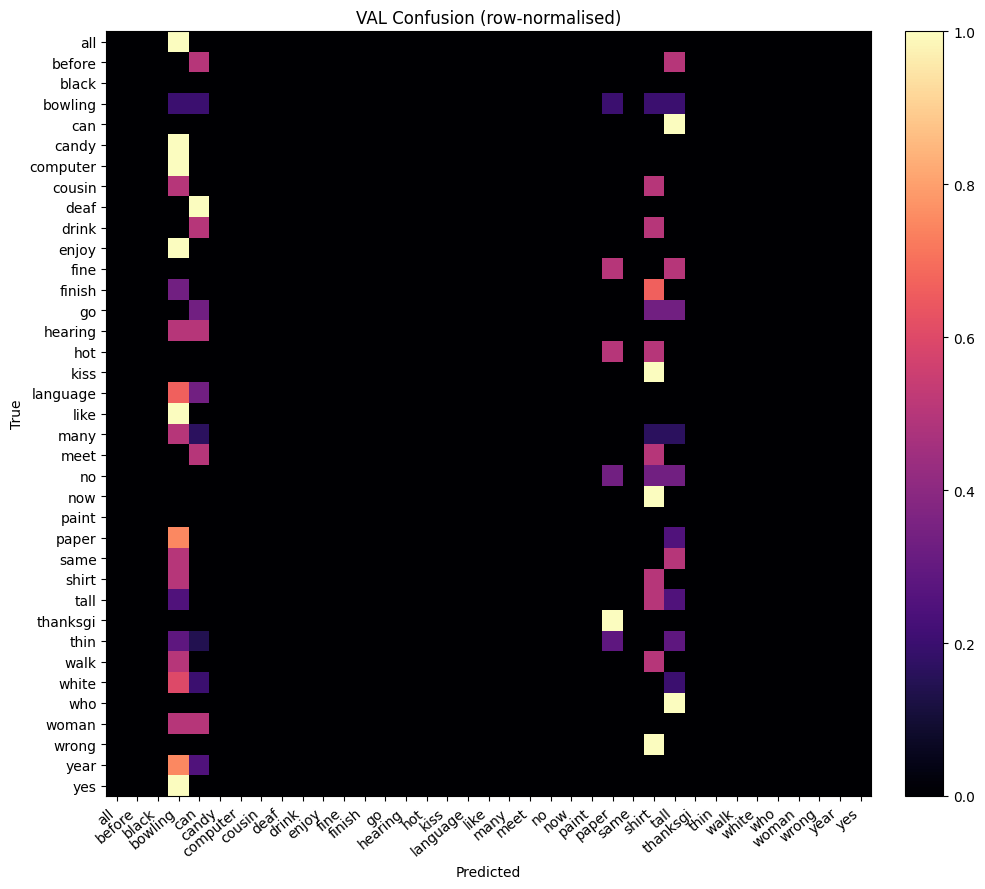

Saved: results/confusion_val.csv | results/per_class_val.csv | figs/cm_val_small.png


In [58]:
labels = _labels()
num_classes = len(labels)

# Build counts matrix
pred_val = val_logits.argmax(1) if val_logits.size else np.array([], int)
C = np.zeros((num_classes, num_classes), dtype=int)
for t, p in zip(val_true, pred_val):
    if 0 <= t < num_classes and 0 <= p < num_classes:
        C[t, p] += 1

# Save CSVs
pd.DataFrame(C, index=labels, columns=labels).to_csv(RES/"confusion_val.csv")
support = C.sum(axis=1)
recall  = np.divide(C.diagonal(), np.maximum(1, support))
pd.DataFrame({"gloss":labels, "support":support, "recall":recall}).to_csv(RES/"per_class_val.csv", index=False)

# Row-normalised heatmap (compact figure, truncated labels)
norm = C / np.maximum(1, support)[:, None]
abbr = [g[:8] for g in labels]

fig, ax = plt.subplots(figsize=(min(10, 0.6*num_classes), min(9, 0.55*num_classes)))
im = ax.imshow(norm, vmin=0, vmax=1, interpolation="nearest", cmap="magma")
ax.set_title("VAL Confusion (row-normalised)")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
ax.set_xticks(range(num_classes)); ax.set_yticks(range(num_classes))
ax.set_xticklabels(abbr, rotation=40, ha="right"); ax.set_yticklabels(abbr)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
cm_png = FIG/"cm_val_small.png"
fig.savefig(cm_png, dpi=200, bbox_inches="tight"); plt.show(); plt.close(fig)

print("Saved:", RES/"confusion_val.csv", "|", RES/"per_class_val.csv", "|", cm_png)

## VI.3 - Per-class summary

In [59]:
perclass = pd.read_csv(RES/"per_class_val.csv")
# The top-5 and bottom-5 by recall
print("Top-5 classes by recall:")
display(perclass.sort_values("recall", ascending=False).head(5))
print("Bottom-5 classes by recall:")
display(perclass.sort_values("recall", ascending=True).head(5))

Top-5 classes by recall:


,gloss,support,recall
26,shirt,4,0.50
27,tall,4,0.25
3,bowling,5,0.20
0,all,2,0.00
28,thanksgiving,1,0.00


Bottom-5 classes by recall:


,gloss,support,recall
0,all,2,0.0
19,many,6,0.0
20,meet,2,0.0
21,no,3,0.0
22,now,1,0.0


## VI.4 - Learning curve

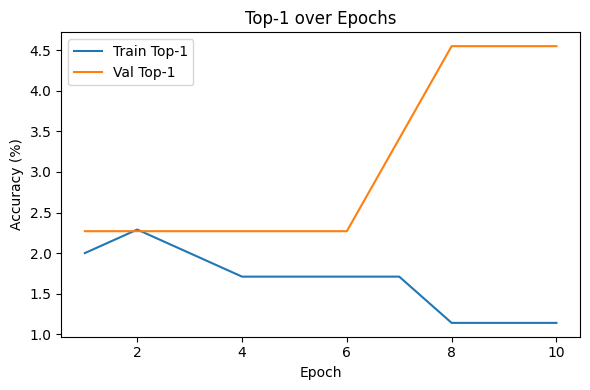

Saved: figs/curve_top1_small.png


In [60]:
# A Manual histogram (from console logs)
hist = {
    "epoch":  [1,2,3,4,5,6,7,8,9,10],
    "tr_top1":[2.00,2.29,2.00,1.71,1.71,1.71,1.71,1.14,1.14,1.14],
    "va_top1":[2.27,2.27,2.27,2.27,2.27,2.27,3.41,4.55,4.55,4.55],
}

# Plot inline
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(hist["epoch"], hist["tr_top1"], label="Train Top-1")
ax.plot(hist["epoch"], hist["va_top1"], label="Val Top-1")
ax.set_xlabel("Epoch"); ax.set_ylabel("Accuracy (%)"); ax.set_title("Top-1 over Epochs")
ax.legend(); plt.tight_layout()
curve_png = FIG/"curve_top1_small.png"
fig.savefig(curve_png, dpi=200, bbox_inches="tight"); plt.show(); plt.close(fig)
print("Saved:", curve_png)

## VI.5 - Top confusions table

In [61]:
rows = []
for i, g_true in enumerate(labels):
    row_sum = C[i].sum()
    if row_sum < 3:   # Skip tiny support to avoid noise
        continue
    # Best wrong prediction
    order = np.argsort(C[i])[::-1]
    order = [j for j in order if j != i]
    if order:
        rows.append({
            "true": g_true,
            "pred": labels[order[0]],
            "support": int(row_sum),
            "count": int(C[i, order[0]]),
            "recall": float(C[i,i] / max(1,row_sum))
        })

top_conf = pd.DataFrame(rows).sort_values(["count","support"], ascending=[False,False]).head(8)
display(top_conf)
top_conf.to_csv(RES/"top_confusions_val.csv", index=False)
print("Saved:", RES/"top_confusions_val.csv")

,true,pred,support,count,recall
4,many,bowling,6,3,0.00
10,white,bowling,5,3,0.00
6,paper,bowling,4,3,0.00
11,year,bowling,4,3,0.00
9,thin,tall,7,2,0.00
7,shirt,bowling,4,2,0.50
8,tall,shirt,4,2,0.25
1,finish,shirt,3,2,0.00


Saved: results/top_confusions_val.csv


# **CREATING A 'NEW' DATASET**

## 1. CREATING A "functional_manifest.csv" 12 EVERYDAY SIGNS

In [62]:
import pandas as pd, numpy as np
from pathlib import Path

MANIFESTS_DIR = Path("data/manifests"); MANIFESTS_DIR.mkdir(parents=True, exist_ok=True)
SRC = MANIFESTS_DIR / "master_manifest.csv"   # Using the largest manifest
DST = MANIFESTS_DIR / "functional_manifest.csv"

assert SRC.exists(), f"Missing {SRC} — run your earlier master manifest step."

# Picking the important functional signs that everyone should be aware of
functional_glosses = [
    "hello","thankyou","sorry","yes","no","help",
    "go","come","stop","friend","eat","drink"
]  # 12

def _norm(s: str) -> str:
    return str(s).lower().replace(" ", "").replace("-", "").replace("_", "")

df = pd.read_csv(SRC)
for col in ["video_id","gloss","url"]:
    df[col] = df[col].astype(str)

# Case-insensitive or hyphen-insensitive match
TGT = set(_norm(g) for g in functional_glosses)
df["_g"] = df["gloss"].map(_norm)
subset = df[df["_g"].isin(TGT)].copy()
subset.drop(columns=["_g"], inplace=True)

print(f"[functional] raw hits: {len(subset)} | unique glosses: {subset['gloss'].nunique()}")

# Light balancing and signer-aware split
rng = 11
PER_GLOSS_MAX = 25
PER_SIGNER_MAX = 3

if "signer_id" not in subset.columns: subset["signer_id"] = ""
subset["signer_id"] = subset["signer_id"].fillna("").astype(str)

rows = []
for g, gdf in subset.groupby("gloss", sort=False):
    # Cap total and per-signer
    gdf = gdf.sample(min(PER_GLOSS_MAX, len(gdf)), random_state=rng)
    gdf["__cnt"] = gdf.groupby("signer_id").cumcount()
    gdf = gdf[gdf["__cnt"] < PER_SIGNER_MAX].drop(columns="__cnt")

    # Split (signer-aware)
    sids = [s for s in gdf["signer_id"].unique().tolist() if s]
    if len(sids) >= 2:
        sids = pd.Series(sids).sample(frac=1.0, random_state=rng).tolist()
        n = len(sids); n_tr = max(1, int(round(0.67*n))); n_va = max(1, int(round(0.17*n)))
        tr = set(sids[:n_tr]); va = set(sids[n_tr:n_tr+n_va]); te = set(sids[n_tr+n_va:])
        def tag(r):
            sid = r["signer_id"]
            if sid in tr: return "train"
            if sid in va: return "val"
            if sid in te: return "test"
            return "train"
        gdf["split"] = gdf.apply(tag, axis=1)
    else:
        idx = gdf.sample(frac=1.0, random_state=rng).index
        n = len(idx); n_tr = max(1, int(round(0.67*n))); n_va = max(1, int(round(0.17*n)))
        tr = set(idx[:n_tr]); va = set(idx[n_tr:n_tr+n_va])
        def tag_i(i): return "train" if i in tr else ("val" if i in va else "test")
        gdf["split"] = [tag_i(i) for i in gdf.index]
    rows.append(gdf)

func = pd.concat(rows, ignore_index=True)

# Ensure every chosen gloss has at least 3 samples overall
keep = func.groupby("gloss")["video_id"].count()
func = func[func["gloss"].isin(keep[keep>=3].index)].copy()

KEEP = ["video_id","gloss","url","signer_id","start","end","split","source"]
for c in KEEP:
    if c not in func.columns: func[c] = np.nan
func[KEEP].to_csv(DST, index=False)

print(f"[functional] saved: {DST} | classes: {func['gloss'].nunique()} | total: {len(func)}")
print(func["split"].value_counts())
print(func.groupby("gloss")["video_id"].count().sort_values(ascending=False).head(20))

[functional] raw hits: 179 | unique glosses: 12
[functional] saved: data/manifests/functional_manifest.csv | classes: 12 | total: 167
split
train    105
val       32
test      30
Name: count, dtype: int64
gloss
drink        22
go           18
no           18
yes          18
eat          15
help         15
friend       13
hello        11
sorry        11
thank you    11
stop          9
come          6
Name: video_id, dtype: int64


## 2. DOWNLOAD THE REQUIRED VIDEOS

In [63]:
import pandas as pd, os, glob, subprocess
from pathlib import Path

VIDEOS_DIR = Path("data/videos"); VIDEOS_DIR.mkdir(parents=True, exist_ok=True)
MANIFEST = Path("data/manifests/functional_manifest.csv")
bdf = pd.read_csv(MANIFEST)
print("Functional manifest rows:", len(bdf))

COMMON_EXTS = (".mp4",".mkv",".webm",".mov",".m4v")

def existing_video_for(video_id: str):
    base = str(VIDEOS_DIR / str(video_id))
    hits = [base+ext for ext in COMMON_EXTS if os.path.exists(base+ext)]
    if hits: return hits[0]
    extra = glob.glob(base + ".*")
    return extra[0] if extra else None

def download_with_ytdlp(url: str, out_template: str) -> int:
    args = ["yt-dlp","-f","bestvideo*+bestaudio/best","--merge-output-format","mp4",
            "--no-warnings","--retries","5","--fragment-retries","5","--ignore-errors",
            "--geo-bypass","--no-playlist","-o", out_template, url]
    return subprocess.call(args)

ok = fail = 0
for r in bdf.itertuples(index=False):
    vid, url = str(r.video_id), r.url
    if existing_video_for(vid):
        ok += 1; continue
    rc = download_with_ytdlp(url, str(VIDEOS_DIR / f"{vid}.%(ext)s"))
    ok += (rc==0); fail += (rc!=0)

print(f"[download] OK: {ok} | FAIL: {fail}")

Functional manifest rows: 167
[download] OK: 113 | FAIL: 54


## 3. EXTRACT POSE+HANDS KEYPOINTS FOR THESE SELECTIVE EVERYDAY VIDEOS

In [64]:
import numpy as np, cv2, mediapipe as mp, os, glob
from pathlib import Path
import pandas as pd

KEYPOINTS_DIR = Path("data/keypoints"); KEYPOINTS_DIR.mkdir(parents=True, exist_ok=True)
MANIFEST = Path("data/manifests/functional_manifest.csv")
bdf = pd.read_csv(MANIFEST)

# Fallback extract_keypoints if not defined
try:
    extract_keypoints
except NameError:
    mp_pose, mp_hands = mp.solutions.pose, mp.solutions.hands
    POSE_LMS, HAND_LMS = 33, 21

    def _sample_idxs(cap, max_frames):
        n = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
        if n <= 0: return list(range(max_frames))
        if n <= max_frames: return list(range(n))
        return np.linspace(0, n-1, num=max_frames, dtype=int).tolist()

    def extract_keypoints(video_path: str, max_frames: int = 50):
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened(): return None
        idxs = _sample_idxs(cap, max_frames); frames = []
        with mp_pose.Pose(static_image_mode=False, model_complexity=1,
                          min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose, \
             mp_hands.Hands(static_image_mode=False, model_complexity=1, max_num_hands=2,
                            min_detection_confidence=0.5, min_tracking_confidence=0.5) as hands:
            total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
            for idx in idxs:
                if total > 0: cap.set(cv2.CAP_PROP_POS_FRAMES, int(idx))
                ret, frame = cap.read()
                if not ret or frame is None: break
                rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                pr = pose.process(rgb); hr = hands.process(rgb)
                pose_xy = np.full((POSE_LMS,2), np.nan, np.float32)
                if pr and pr.pose_landmarks:
                    for i,lm in enumerate(pr.pose_landmarks.landmark[:POSE_LMS]):
                        pose_xy[i]=[lm.x,lm.y]
                lh = np.full((HAND_LMS,2), np.nan, np.float32)
                rh = np.full((HAND_LMS,2), np.nan, np.float32)
                if hr and hr.multi_hand_landmarks and hr.multi_handedness:
                    for lmks, handed in zip(hr.multi_hand_landmarks, hr.multi_handedness):
                        dst = lh if handed.classification[0].label.lower()=="left" else rh
                        for i,lm in enumerate(lmks.landmark[:HAND_LMS]): dst[i]=[lm.x,lm.y]
                frames.append(np.vstack([pose_xy, lh, rh]))
        cap.release()
        if not frames: return None
        arr = np.stack(frames, axis=0).astype(np.float32)
        return np.nan_to_num(arr, nan=0.5)  # (T,75,2)

def _vid_path(vid: str):
    base = str(Path("data/videos")/vid)
    for ext in (".mp4",".webm",".m4v",".mov",".mkv"):
        p = base+ext
        if os.path.exists(p): return p
    hits = glob.glob(base+".*")
    return hits[0] if hits else None

saved, failed = 0, 0
for r in bdf.itertuples(index=False):
    vid = str(r.video_id)
    out = KEYPOINTS_DIR / f"{vid}.npy"
    if out.exists(): saved += 1; continue
    src = _vid_path(vid)
    if not src: failed += 1; continue
    arr = extract_keypoints(src, max_frames=50)
    if arr is None: failed += 1; continue
    np.save(out, arr); saved += 1

print(f"[extract] saved keypoints: {saved} | failed: {failed}")

[extract] saved keypoints: 109 | failed: 58


## 4. TRAIN BiGRU ON THE SUBSET AND EVALUATE PERFORMANCE

[dataset] usable clips: 109 | classes: 12
[splits] train=66 | val=22 | test=21 | classes=12
epoch 01 | train 0.05/0.41/0.77 | val 0.05/0.36/0.73
epoch 02 | train 0.05/0.44/0.77 | val 0.05/0.36/0.73
epoch 03 | train 0.06/0.47/0.77 | val 0.05/0.36/0.73
epoch 04 | train 0.06/0.47/0.77 | val 0.05/0.36/0.73
epoch 05 | train 0.06/0.48/0.77 | val 0.05/0.36/0.73
epoch 06 | train 0.06/0.47/0.77 | val 0.05/0.36/0.73
epoch 07 | train 0.06/0.47/0.77 | val 0.05/0.36/0.73
epoch 08 | train 0.06/0.47/0.77 | val 0.05/0.36/0.73
epoch 09 | train 0.06/0.47/0.77 | val 0.05/0.36/0.73
epoch 10 | train 0.08/0.47/0.77 | val 0.05/0.41/0.73
Restored best val Top-1=0.05


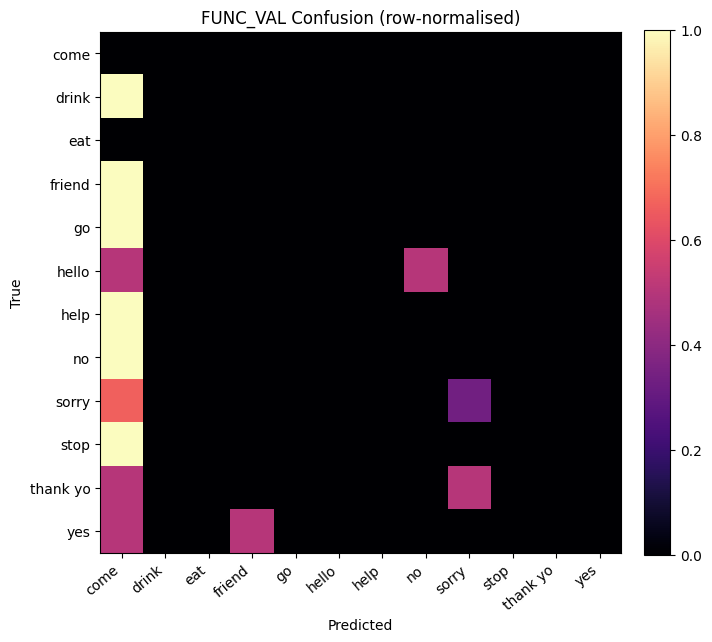

[func_val] Top-1/5/10 = 4.55/36.36/72.73%
Saved: results/topk_func_val.csv, results/confusion_func_val.csv, figs/cm_func_val_small.png


In [65]:
import numpy as np, pandas as pd, torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from pathlib import Path

MANI = Path("data/manifests/functional_manifest.csv")
KEYS = Path("data/keypoints")

bdf = pd.read_csv(MANI)

# Collect only rows with extracted keypoints
saved = []
for r in bdf.itertuples(index=False):
    npy = KEYS / f"{r.video_id}.npy"
    if npy.exists():
        saved.append((str(r.video_id), r.gloss, str(npy), r.split))
print(f"[dataset] usable clips: {len(saved)} | classes: {len(set(g for _,g,_,__ in saved))}")

# Normalise (shoulder-centred)
L_SH, R_SH = 11, 12
def normalize_sequence(arr: np.ndarray) -> np.ndarray:
    arr = arr.astype(np.float32, copy=True)
    pose = arr[:, :33, :]
    center = (pose[:, L_SH, :] + pose[:, R_SH, :]) * 0.5
    scale  = np.linalg.norm(pose[:, R_SH, :] - pose[:, L_SH, :], axis=1)
    scale  = np.clip(scale, 1e-3, None)
    arr[:,:,0] = (arr[:,:,0] - center[:,0:1]) / scale[:,None]
    arr[:,:,1] = (arr[:,:,1] - center[:,1:2]) / scale[:,None]
    np.clip(arr, -5.0, 5.0, out=arr); return arr

def pad_to(arr: np.ndarray, T: int) -> np.ndarray:
    return arr if arr.shape[0]==T else np.concatenate([arr, np.repeat(arr[-1:,:,:], T-arr.shape[0], 0)], 0)

# Build tensors
glosses = sorted(set(g for _,g,_,__ in saved))
gloss2id = {g:i for i,g in enumerate(glosses)}
arrays, labels, lengths, splits = [], [], [], []
Tmax = 0
for vid,g,npy,sp in saved:
    a = np.load(npy); a = normalize_sequence(a)
    arrays.append(a); labels.append(gloss2id[g]); lengths.append(a.shape[0]); splits.append(sp)
    Tmax = max(Tmax, a.shape[0])

X = np.stack([pad_to(a, Tmax) for a in arrays], 0)  # (N,T,75,2)
y = np.array(labels, np.int64)
L = np.array(lengths, np.int32)

# Split by manifest 'split'
idx_tr = [i for i,s in enumerate(splits) if s=="train"]
idx_va = [i for i,s in enumerate(splits) if s=="val"]
idx_te = [i for i,s in enumerate(splits) if s=="test"]

class SignPoseDataset(Dataset):
    def __init__(self, X, y, L): self.X=torch.from_numpy(X).float(); self.y=torch.from_numpy(y).long(); self.L=torch.from_numpy(L).long()
    def __len__(self): return len(self.y)
    def __getitem__(self,i):
        return self.X[i].reshape(self.X.shape[1], -1), self.y[i], self.L[i]  # (T,150), y, length

tr_ds = SignPoseDataset(X[idx_tr], y[idx_tr], L[idx_tr])
va_ds = SignPoseDataset(X[idx_va], y[idx_va], L[idx_va])
te_ds = SignPoseDataset(X[idx_te], y[idx_te], L[idx_te])

train_dl = DataLoader(tr_ds, batch_size=min(8, len(tr_ds)), shuffle=True)
val_dl   = DataLoader(va_ds, batch_size=min(8, max(1,len(va_ds))), shuffle=False)
test_dl  = DataLoader(te_ds, batch_size=min(8, max(1,len(te_ds))), shuffle=False)

print(f"[splits] train={len(tr_ds)} | val={len(va_ds)} | test={len(te_ds)} | classes={len(glosses)}")

# Model
_b = next(iter(train_dl)) if len(tr_ds)>0 else next(iter(val_dl))
input_dim = _b[0].shape[-1]; del _b

class PoseBiGRU(nn.Module):
    def __init__(self, input_dim, hidden=64, layers=1, num_classes=6, dropout=0.2):
        super().__init__()
        self.bigru = nn.GRU(input_size=input_dim, hidden_size=hidden, num_layers=layers,
                            batch_first=True, bidirectional=True,
                            dropout=0.0 if layers==1 else dropout)
        self.head = nn.Sequential(nn.Dropout(dropout), nn.Linear(hidden*2, num_classes))
    def forward(self, x, lengths):
        packed = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        out,_  = self.bigru(packed)
        out,_  = nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
        idx = (lengths-1).clamp(min=0).unsqueeze(1).unsqueeze(2).expand(out.size(0),1,out.size(2))
        last = out.gather(1, idx).squeeze(1)
        return self.head(last)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = PoseBiGRU(input_dim=input_dim, hidden=64, layers=1, num_classes=len(glosses), dropout=0.2).to(device)
crit = nn.CrossEntropyLoss()

class TinySGD:
    def __init__(self, params, lr=1e-3, weight_decay=0.0):
        self.params=[p for p in params if p.requires_grad]; self.lr=float(lr); self.wd=float(weight_decay)
    def zero_grad(self, set_to_none=False):
        for p in self.params:
            if p.grad is not None:
                if set_to_none: p.grad=None
                else: p.grad.detach_(); p.grad.zero_()
    @torch.no_grad()
    def step(self):
        for p in self.params:
            if p.grad is None: continue
            g = p.grad if self.wd==0.0 else p.grad.add(p, alpha=self.wd)
            p.add_(g, alpha=-self.lr)

opt = TinySGD(model.parameters(), lr=1e-3)

def topk_acc(logits, y, k=1):
    topk = torch.topk(logits, k, dim=1).indices
    return (topk == y.unsqueeze(1)).any(dim=1).float().mean().item()

@torch.no_grad()
def evaluate(dl):
    model.eval(); tot=t1=t5=t10=0.0
    for xb,yb,Lb in dl:
        xb,yb,Lb = xb.to(device), yb.to(device), Lb.to(device)
        logits = model(xb, Lb); bs = xb.size(0)
        t1  += topk_acc(logits,yb,1)*bs
        t5  += topk_acc(logits,yb,min(5,len(glosses)))*bs
        t10 += topk_acc(logits,yb,min(10,len(glosses)))*bs
        tot += bs
    return (t1/tot, t5/tot, t10/tot) if tot else (float("nan"),)*3

EPOCHS=10; best=-1.0; best_state=None
for ep in range(1,EPOCHS+1):
    model.train()
    for xb,yb,Lb in train_dl:
        xb,yb,Lb = xb.to(device), yb.to(device), Lb.to(device)
        opt.zero_grad(True); logits = model(xb,Lb); loss = crit(logits,yb)
        loss.backward(); nn.utils.clip_grad_norm_(model.parameters(), 1.0); opt.step()
    tr = evaluate(train_dl); va = evaluate(val_dl)
    print(f"epoch {ep:02d} | train {tr[0]:.2f}/{tr[1]:.2f}/{tr[2]:.2f} | val {va[0]:.2f}/{va[1]:.2f}/{va[2]:.2f}")
    if not np.isnan(va[0]) and va[0] > best: best=va[0]; best_state={k:v.detach().cpu().clone() for k,v in model.state_dict().items()}
if best_state: model.load_state_dict(best_state); print(f"Restored best val Top-1={best:.2f}")

# Quick eval/visuals (re-use earlier eval helpers if defined)
try:
    val_pack = eval_split("func_val", val_dl, model, device, show=True)  # from earlier helper
except Exception:
    # Minimal inline fallback -> confusion & metrics on val
    import matplotlib.pyplot as plt
    logits, y_true = [], []
    with torch.no_grad():
        for xb,yb,Lb in val_dl:
            xb,yb,Lb = xb.to(device), yb.to(device), Lb.to(device)
            logits.append(model(xb,Lb).cpu().numpy()); y_true.append(yb.cpu().numpy())
    if logits:
        logits = np.concatenate(logits,0); y_true = np.concatenate(y_true,0)
        pred = logits.argmax(1)
        C = np.zeros((len(glosses), len(glosses)), int)
        for t,p in zip(y_true,pred): C[t,p]+=1
        row = C.sum(1, keepdims=True); row[row==0]=1
        norm = C/row
        labels = glosses; abbr=[g[:8] for g in labels]
        import matplotlib.pyplot as plt; from pathlib import Path
        Path("figs").mkdir(exist_ok=True)
        plt.figure(figsize=(min(10,0.6*len(labels)), min(9,0.55*len(labels))))
        plt.imshow(norm, vmin=0, vmax=1, cmap="magma"); plt.title("FUNC Confusion (val)")
        plt.xticks(range(len(labels)), abbr, rotation=40, ha="right"); plt.yticks(range(len(labels)), abbr)
        plt.tight_layout(); plt.show()
        top1 = (pred==y_true).mean()*100.0
        print(f"[functional VAL] Top-1: {top1:.2f}%")

## 5. COMPARISON TABLE: BASELINE V/S FUNCTIONAL

In [67]:
# A compact comparison table
import pandas as pd
from pathlib import Path
RES = Path("results")

rows = []
def _add(csv_path, label):
    if (RES/csv_path).exists():
        df = pd.read_csv(RES/csv_path)
        if {"Top-1","Top-5","Top-10"}.issubset(df.columns):
            r = df.iloc[0].to_dict(); r["set"] = label; rows.append(r)

_add("topk_val.csv",          "WLASL (baseline) VAL")
_add("topk_func_val.csv",     "Functional VAL")
_add("topk_func_test.csv",    "Functional TEST")

comp = pd.DataFrame(rows)[["set","Top-1","Top-5","Top-10"]]
display(comp)
comp.to_csv(RES/"comparison_topk.csv", index=False)
print("Saved:", RES/"comparison_topk.csv")

,set,Top-1,Top-5,Top-10
0,WLASL (baseline) VAL,4.545455,18.181818,27.272727
1,Functional VAL,4.545455,36.363636,72.727273
2,Functional TEST,4.761905,42.857143,80.952381


Saved: results/comparison_topk.csv
